# INFO-F-422 - Statistical foundations of Machine Learning


### Abdessettar Djelti - [abdessettar.djelti@ulb.be](mailto:abdessettar.djelti@ulb.be) 
### Yassin Sahraoui - [yassin.sahraoui@ulb.be](mailto:yassin.sahraoui@ulb.be) 


## Project Title - Pump it UP: Data Mining the Water Table

In [1]:
library(dplyr)
library(leaflet)
library(data.table)
library(dplyr)
library(dummies)
library(tibble)
library(e1071)
library(randomForest)
library(glmnet)
library(corrplot)
library(caret)
library(xgboost)
library(nnet)
library(NeuralNetTools)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


dummies-1.5.6 provided by Decision Patterns


randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: Matrix

Loaded glmnet 4.1-1

corrplot 0.84 loaded

Loading required package: lattice

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin



Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice




# Data preprocessing

In [2]:
#import both training csv files and merge them into one data frame called training
training_values <- read.csv("Training set values.csv",stringsAsFactors = T, header = TRUE)
training_labels <- read.csv("Training set labels.csv", header = TRUE)
test <- read.csv("Test set values.csv", header = TRUE)
all.equal(training_values$id, training_labels$id)
train <- merge(x = training_values, y = training_labels,by="id", type="inner")
Y_1 <- train$status_group
Y <- ifelse(Y_1 == "functional", 0, ifelse( Y_1 == "non functional", 1, 2))

[1] TRUE

In [3]:
head(train)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,⋯,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
,<int>,<dbl>,<fct>,<fct>,<int>,<fct>,<dbl>,<dbl>,<fct>,<int>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,0,0,2012-11-13,Tasaf,0,TASAF,33.12583,-5.118154,Mratibu,0,⋯,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
2,1,0,2011-03-05,Shipo,1978,SHIPO,34.77072,-9.395642,none,0,⋯,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
3,2,0,2011-03-27,Lvia,0,LVIA,36.11506,-6.279268,Bombani,0,⋯,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional
4,3,10,2013-06-03,Germany Republi,1639,CES,37.14743,-3.187555,Area 7 Namba 5,0,⋯,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
5,4,0,2011-03-22,Cmsr,0,CMSR,36.16489,-6.099289,Ezeleda,0,⋯,soft,good,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
6,5,50,2011-02-26,Private,28,Private,39.28612,-6.972403,Kwa Namaj,0,⋯,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional


We checked whether the training set and the test contain the same features.

In [4]:
a=0
for (i in 1:length(names(test))){ 
    if (names(train[i])==names(test)[i]) {
        a=a+1
        }
}    
if (a==length(names(test))) {
    print("ok")
}


[1] "ok"


Create `data` which containts both the training and test set. (Only the values and not labels for the training set.)

In [5]:
train_without_y=subset(train, select = -c(status_group))
data=rbind(train_without_y,test)
dim(data)

[1] 74250    40

Here are all the features available to us in the data set.

In [6]:
names(data)

[1] "id"                    "amount_tsh"            "date_recorded"        
 [4] "funder"                "gps_height"            "installer"            
 [7] "longitude"             "latitude"              "wpt_name"             
[10] "num_private"           "basin"                 "subvillage"           
[13] "region"                "region_code"           "district_code"        
[16] "lga"                   "ward"                  "population"           
[19] "public_meeting"        "recorded_by"           "scheme_management"    
[22] "scheme_name"           "permit"                "construction_year"    
[25] "extraction_type"       "extraction_type_group" "extraction_type_class"
[28] "management"            "management_group"      "payment"              
[31] "payment_type"          "water_quality"         "quality_group"        
[34] "quantity"              "quantity_group"        "source"               
[37] "source_type"           "source_class"          "waterpoint_type"      
[40] "waterpoint_type_group"

What can be directly see is that there is an imbalance in terms of pump statu

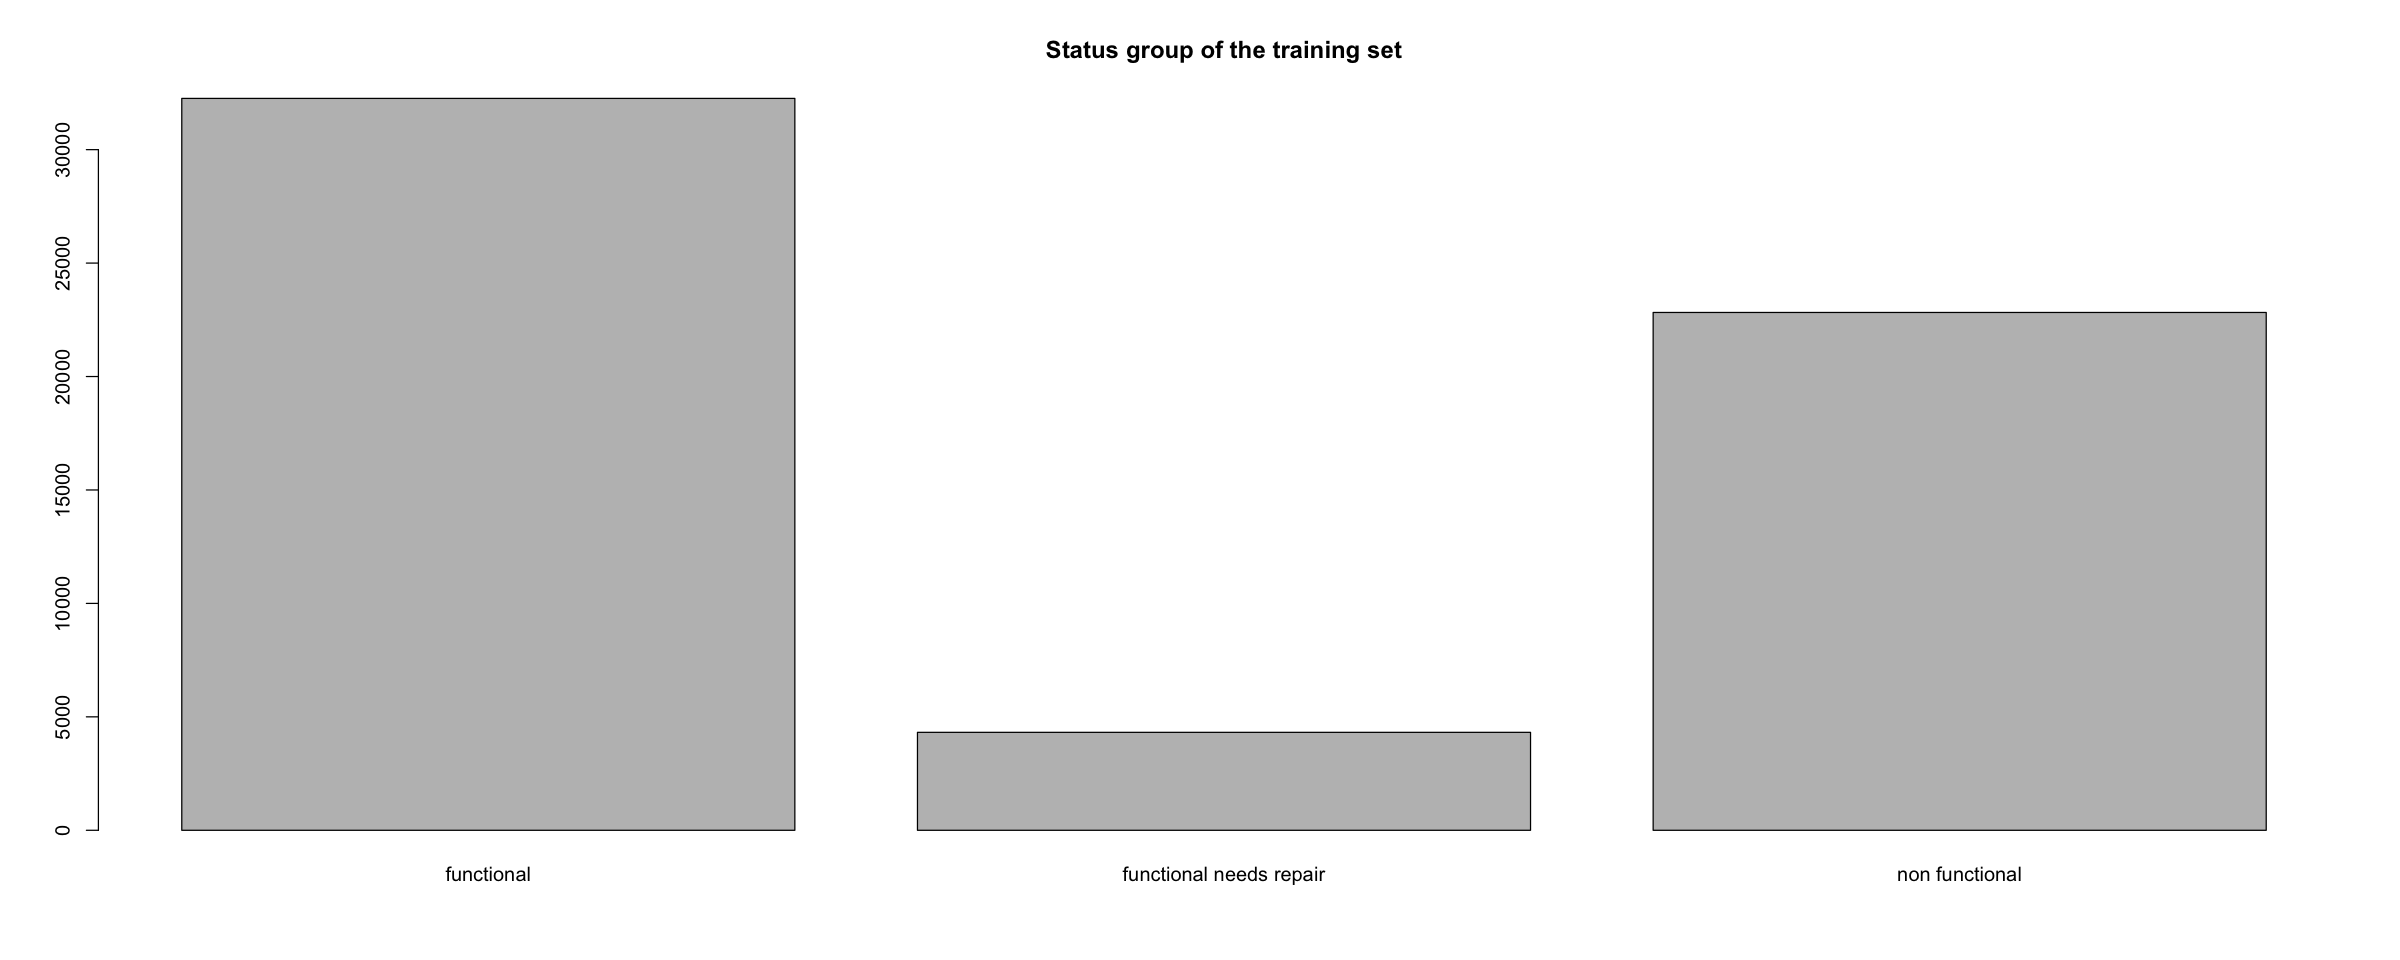

In [7]:
options(repr.plot.width = 20, repr.plot.height = 8)
plot(train$status_group, main="Status group of the training set")

In [8]:
summary(train)

       id          amount_tsh          date_recorded  
 Min.   :    0   Min.   :     0.0   2011-03-15:  572  
 1st Qu.:18520   1st Qu.:     0.0   2011-03-17:  558  
 Median :37062   Median :     0.0   2013-02-03:  546  
 Mean   :37115   Mean   :   317.7   2011-03-14:  520  
 3rd Qu.:55656   3rd Qu.:    20.0   2011-03-16:  513  
 Max.   :74247   Max.   :350000.0   2011-03-18:  497  
                                    (Other)   :56194  
                    funder        gps_height          installer    
 Government Of Tanzania: 9084   Min.   : -90.0   DWE       :17402  
                       : 3635   1st Qu.:   0.0             : 3655  
 Danida                : 3114   Median : 369.0   Government: 1825  
 Hesawa                : 2202   Mean   : 668.3   RWE       : 1206  
 Rwssp                 : 1374   3rd Qu.:1319.2   Commu     : 1060  
 World Bank            : 1349   Max.   :2770.0   DANIDA    : 1050  
 (Other)               :38642                    (Other)   :33202  
   longitude    

**We decided to analyse the features one after the other as it seems that they all have different behaviors.**

## Location features

`region`, `region_code`, `district_code`, `ward`, `subvillage`, `lga`, `longitude` and `latitude` all refer to location with different level of precision. 
We decided to keep only region (as a categorical feature) and longitude and latitude.

In [9]:
map.df <- train %>% select(latitude, longitude) 

leaflet() %>% addTiles() %>% addMarkers(lat = map.df$latitude,
                                        lng = map.df$longitude,
                                        clusterOptions = markerClusterOptions())


HTML widgets cannot be represented in plain text (need html)

In [10]:
length(train[,"longitude"][(train[,"longitude"] %in% c(NA,0,""," ","-","_"))])
length(train[,"latitude"][(train[,"latitude"] %in% c(NA,0,""," ","_"))])
length(test[,"longitude"][(test[,"longitude"] %in% c(NA,0,""," ","-","_"))])
length(test[,"latitude"][(test[,"latitude"] %in% c(NA,0,""," ","_"))])

[1] 1812

[1] 0

[1] 457

[1] 0

However, as can be seen 1812 data points of the training set are in the middle of the ocean. They correspond to latitude and longitude 0 points. 

Therefore, we decided to replace missing longitude/latitude values by district in each region mean latitude and longitude.But for some districts in some regions it is not possible to compute its average longitude and latitude (because only one data point refers to the district code) and in this case we computed the average latitude and longitude of the region directly.

In [11]:
replace_missing_lat_long <- function(data){
    
    data$latitude[data$latitude==0]<-NA
    data$longitude[data$longitude==0]<-NA

    data = data %>% 
    group_by(region,district_code) %>%
    mutate(district.long = mean(longitude, na.rm = TRUE)) %>%
    mutate(district.lat = mean(latitude, na.rm = TRUE)) %>%
    ungroup()

## Replace missing longitude/latitude values by district in each region mean latitude and longitude.
##But for some districts in some regions it is not possible to compute its average long and lat and in this
## case we computed the average lat and long of the region directly.
    data = data %>%
    group_by(region) %>%
    mutate(region.long = mean(longitude, na.rm = TRUE)) %>%
    mutate(region.lat = mean(latitude, na.rm = TRUE)) %>%
    ungroup()
    
    data = data %>%
    mutate(longitude = ifelse(!is.na(longitude), longitude,
                            ifelse(!is.na(district.long), district.long, region.long))) %>%
    mutate(latitude = ifelse(!is.na(latitude), latitude,
                           ifelse(!is.na(district.lat), district.lat, region.lat)))
    
    
    data=subset(data, select = -c(district.long,district.lat,region.long,region.lat))

    return(as.data.frame(data))
}

train=replace_missing_lat_long(train)
test=replace_missing_lat_long(test)
data=replace_missing_lat_long(data)

In [12]:
length(train[,"longitude"][(train[,"longitude"] %in% c(NA,0,""," ","-","_"))])
length(train[,"latitude"][(train[,"latitude"] %in% c(NA,0,""," ","_"))])
length(test[,"longitude"][(test[,"longitude"] %in% c(NA,0,""," ","-","_"))])
length(test[,"latitude"][(test[,"latitude"] %in% c(NA,0,""," ","_"))])
length(data[,"longitude"][(data[,"longitude"] %in% c(NA,0,""," ","-","_"))])
length(data[,"latitude"][(data[,"latitude"] %in% c(NA,0,""," ","_"))])
#Ok job done

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

We then removed all the redundant features that we will not use.

In [13]:
Remove_redundant_location <- function(data) { 
    data=subset(data, select = -c(region_code,district_code,ward,subvillage,lga))
    return(data)
}
            
train=Remove_redundant_location(train)
test=Remove_redundant_location(test)
data=Remove_redundant_location(data)

In [14]:
dim(train)

[1] 59400    36

### DATE features

In [15]:
length(train[,"construction_year"][(train[,"construction_year"] %in% c(NA,0,""," ","-","_"))])
length(train[,"date_recorded"][(train[,"date_recorded"] %in% c(NA,0,""," ","-","_"))])


[1] 20709

[1] 0

In [16]:
length(which(train$construction_year==0))/length(train$construction_year)

[1] 0.3486364

Concerning the time dataframe we dispose of two features in the dataset `construction_year` and `date_recorded`. 

As can be seen 34.8% of the `construction_year` are missing (=0). We could hypothetise that their are missing because they were constructed a very long time ago and have, therefore, more risk to be non functional.

However, the probability distribution of `status_group` among the `construction_year` that are missing is the same than the one that are not missing.

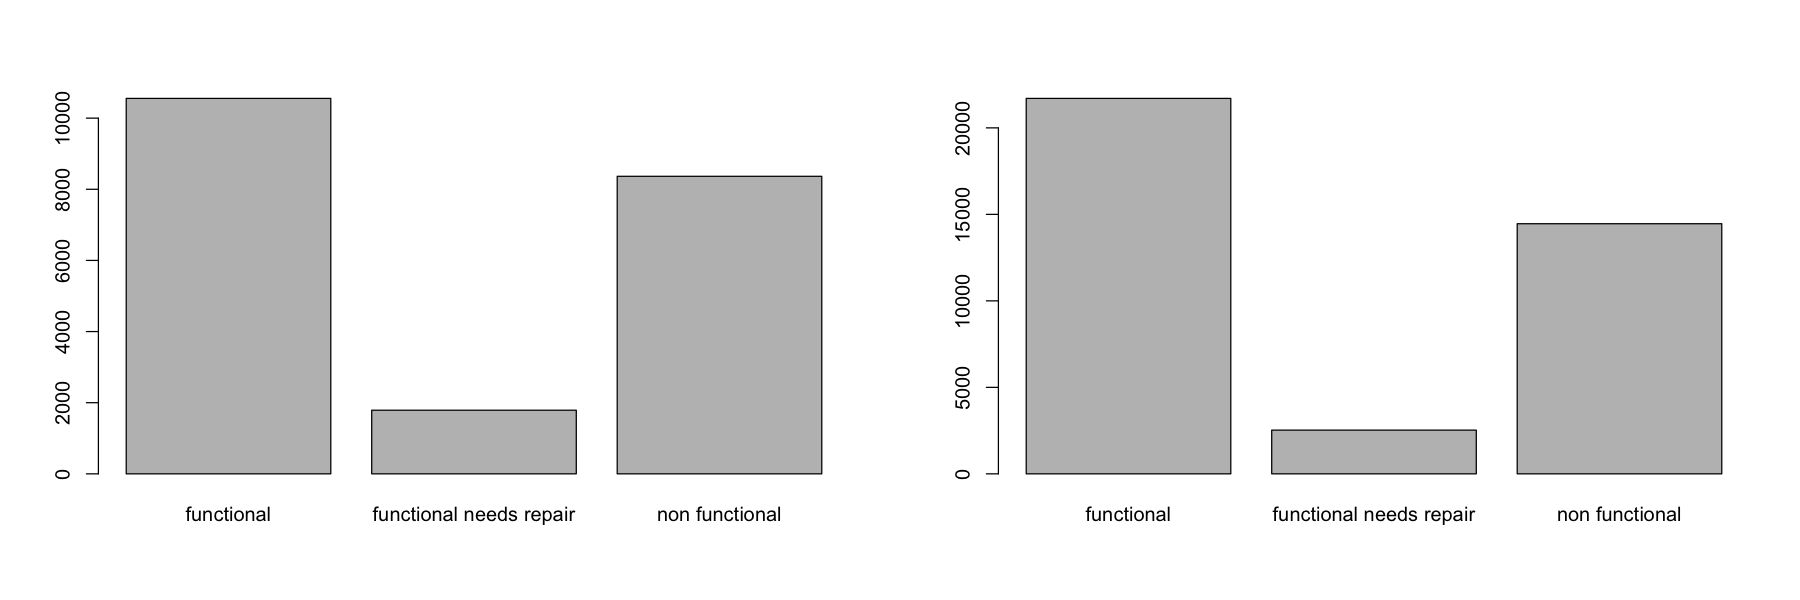

In [17]:
par(mfrow=c(1,2))
options(repr.plot.width = 15, repr.plot.height = 5)

date_0 <- train[train$construction_year==0, ]
plot(date_0$status_group)

date_not_missing <- train[train$construction_year!=0, ]
plot(date_not_missing$status_group)

In [18]:
a=difftime(as.Date(data$date_recorded,format="%Y-%m-%d") 
             ,as.Date(ISOdate(data$construction_year,1,1)) , units = c("days"))
a[(difftime(as.Date(data$date_recorded,format="%Y-%m-%d"),as.Date(ISOdate(data$construction_year,1,1)) , units = c("days"))) < 0 ]

Time differences in days
 [1] -1126 -1036  -306 -1762 -1340 -1767 -2405 -1821  -396 -1458 -2405  -579

We decided to create a variable `age`to compute the approximate age of the pump (in days).
We computed the age of the pump in days and if the construction year or recorded date were missing we replaced them by the median age of the pumps. 

We also found that in some cases the `construction_year` was after the `date_recorded` we therefore also replaced these cases by the median age. (as can be seen above)

In [19]:
convert_Date_to_Age <- function (data) {
    record=data$date_recorded
    construction=data$construction_year

    record[record == 0] <- NA
    construction[construction == 0] <- NA #
    
    age=difftime(as.Date(record,format="%Y-%m-%d") 
             ,as.Date(ISOdate(construction,1,1)) , units = c("days")) #Compute 
    
    age=as.numeric(age)
    age[age<0]<-NA
    age[is.na(age)] = median(age, na.rm=TRUE)

    
    data=subset(data, select = -construction_year )

    data$date_recorded=age
    
    colnames(data)[which(names(data) == "date_recorded")] <- "age"
    
    return(data)
}

train=convert_Date_to_Age(train)
test=convert_Date_to_Age(test)
data=convert_Date_to_Age(data)

In [23]:
dim(train)
dim(test)
dim(data)

[1] 59400    35

[1] 14850    34

[1] 74250    34

In [24]:
head(train)

,id,amount_tsh,age,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,⋯,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
,<int>,<dbl>,<dbl>,<fct>,<int>,<fct>,<dbl>,<dbl>,<fct>,<int>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,0,0,4775,Tasaf,0,TASAF,33.12583,-5.118154,Mratibu,0,⋯,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
2,1,0,1159,Shipo,1978,SHIPO,34.77072,-9.395642,none,0,⋯,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
3,2,0,4775,Lvia,0,LVIA,36.11506,-6.279268,Bombani,0,⋯,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional
4,3,10,5267,Germany Republi,1639,CES,37.14743,-3.187555,Area 7 Namba 5,0,⋯,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
5,4,0,4775,Cmsr,0,CMSR,36.16489,-6.099289,Ezeleda,0,⋯,soft,good,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
6,5,50,4775,Private,28,Private,39.28612,-6.972403,Kwa Namaj,0,⋯,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional


### Features that we decided to drop 

We dropped the `num_private` feature as it equals 0 98.7% of the time.

In [25]:
length(train$num_private[train$num_private==0])/length(train$num_private)

[1] 0.9872559

We dropped the `num_private` feature as it equals 0 98.7% of the time and the probability distribution of `status_group` among the `num_private` that are equal to 0 is the same than the one that are not. Moreover, we have no information concerning what `num_private` represents.

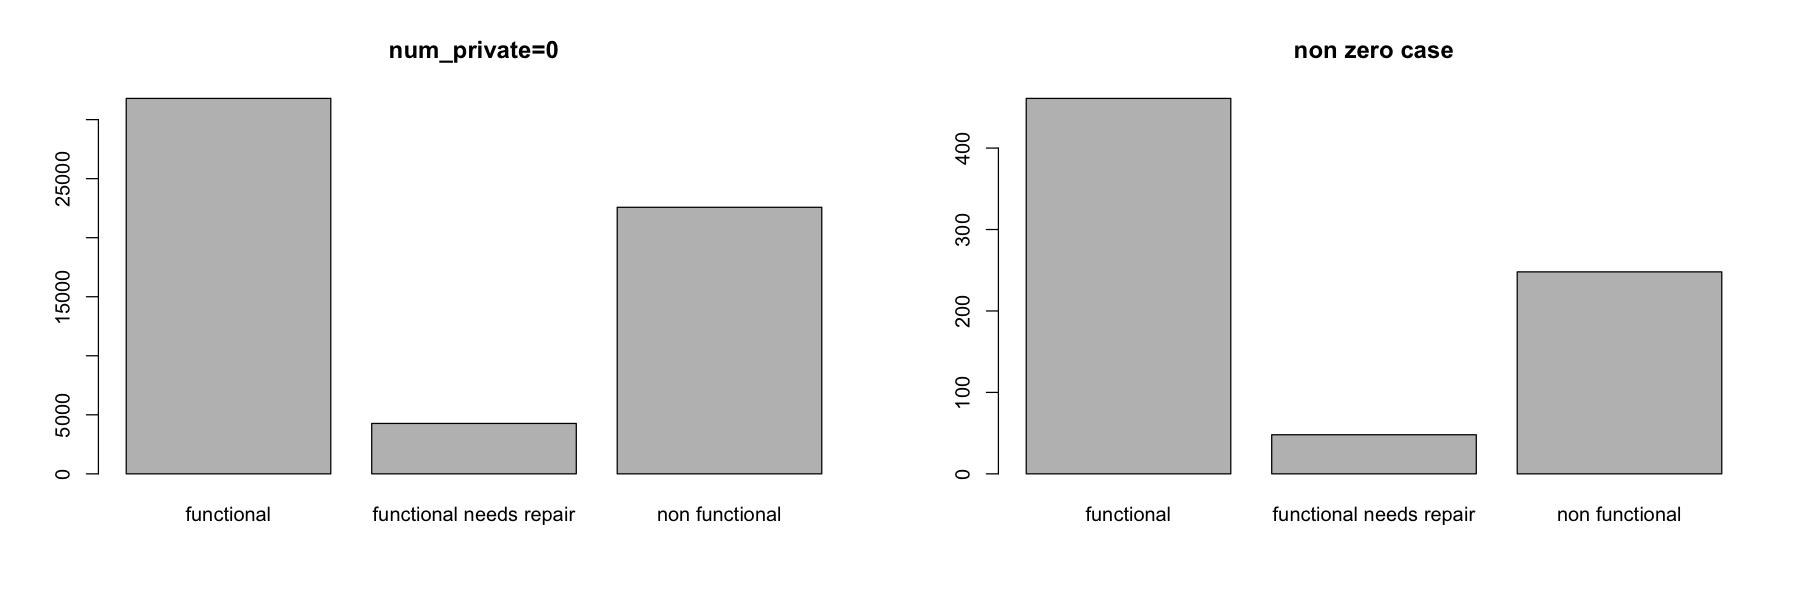

In [26]:
par(mfrow=c(1,2))
options(repr.plot.width = 15, repr.plot.height = 5)

plot(train$status_group[train$num_private==0],main="num_private=0")
plot(train$status_group[train$num_private!=0],main="non zero case")

We also dropped `wpt`feature as there are 37.400 different categories. We also dropped `recorded_by` and `id` as they have no interest. 

In [27]:
categories <- unique(train$wpt_name) 
numberOfCategories <- length(categories)
numberOfCategories

[1] 37400

In [28]:
drop_features <- function (data) {
   
    data=subset(data, select = -c(num_private,recorded_by,id,wpt_name))
    return(data)
}
train=drop_features(train)
test=drop_features(test)
data=drop_features(data)

### Numerical features

We now consider the numerical variables:
`population`,`amount_tsh` and `gps_height`.

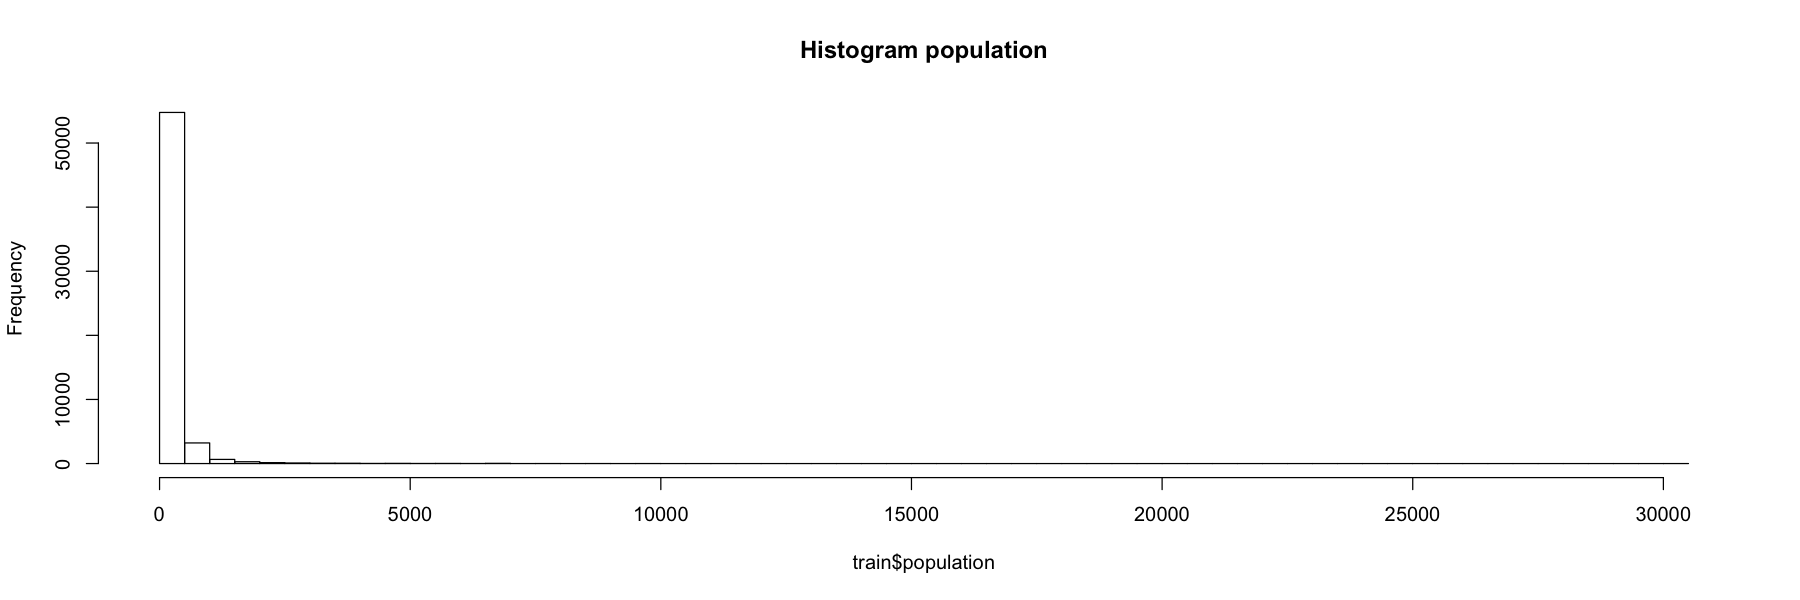

In [29]:
hist(train$population,breaks=100,main="Histogram population")

In [30]:
length(train$population[train$population==0])/length(train$population)

[1] 0.3599495

What can be seen is that the distribution of the population is highly skewed and 35.99% of the time =0. We suggest that it may come from a data collection issue. But we cannot be sure as the only information we get for this variable is "Population around the well". Around as no explanation (It could be 1km or 100m). We decided to take a logarithmic scale and keep the feature as it is.

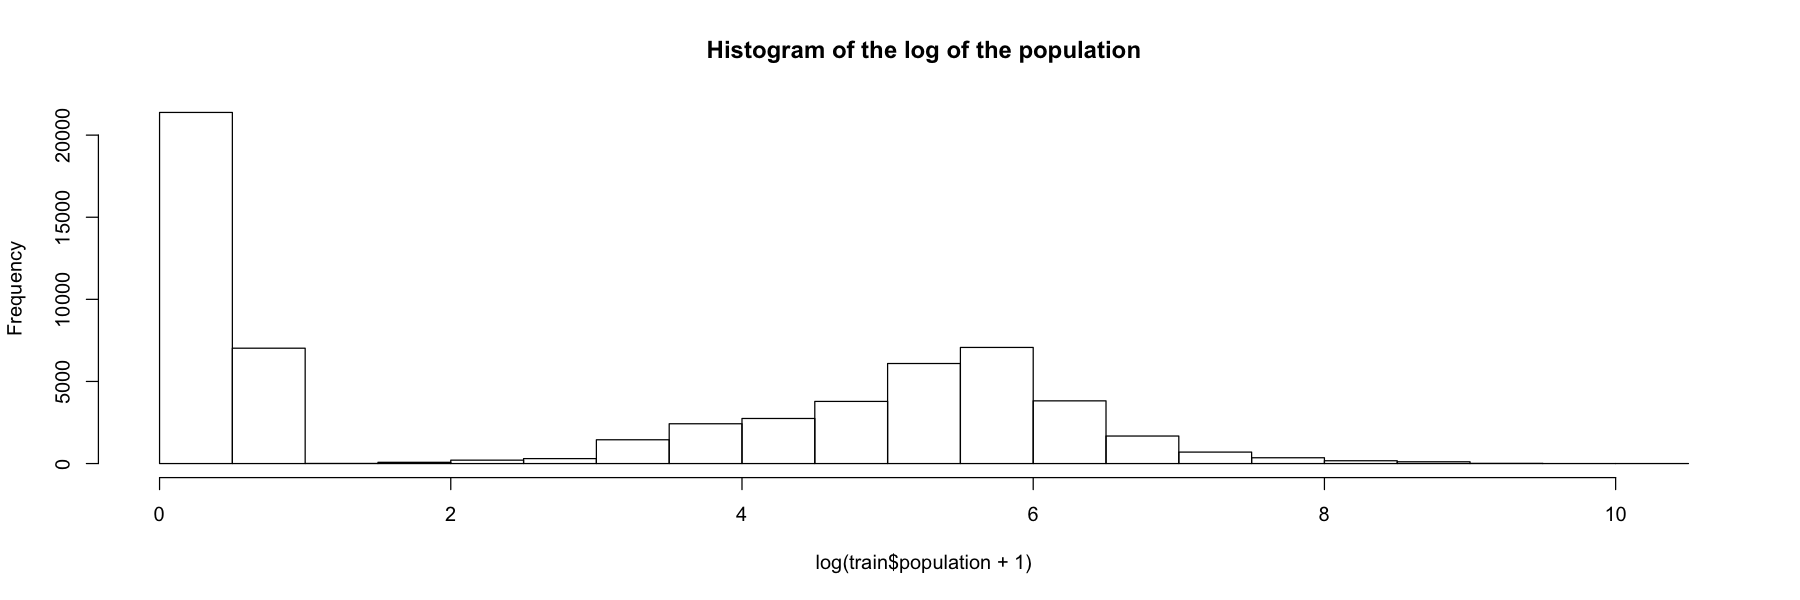

In [31]:
hist(log(train$population+1), main="Histogram of the log of the population")

Concerning the `amount_tsh` feature even if it equals 0 70% of the time we decided to keep it as the distribution of pumps status isn't the same for zero and non zero cases. And it seems that the higher the amount_tsh the lower the number of non functional pump.

In [32]:
length(train$amount_tsh[(train$amount_tsh%in% c(0))])/nrow(train)

[1] 0.7009933

In [33]:
summary(train$amount_tsh[train$amount_tsh!=0])

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
     0.2     50.0    250.0   1062.4   1000.0 350000.0 

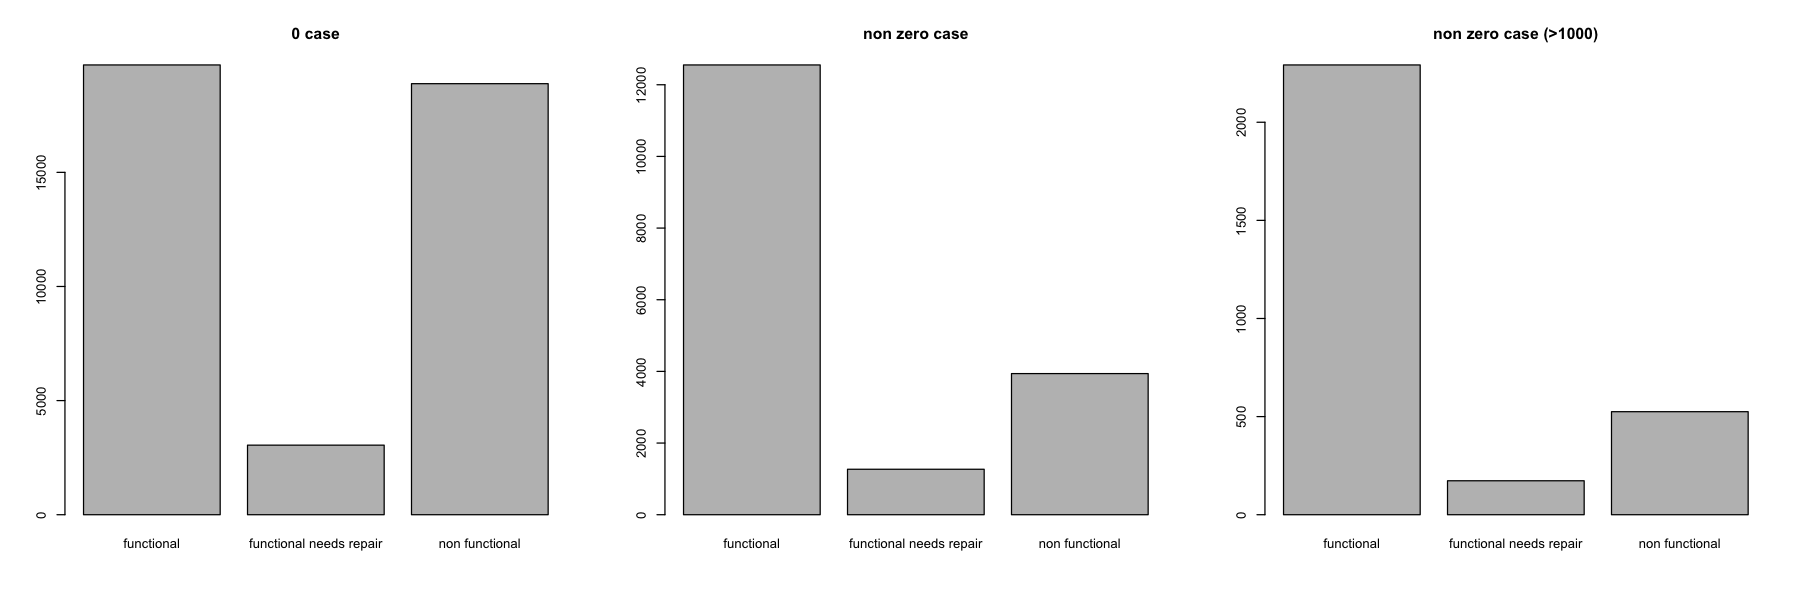

In [34]:
par(mfrow=c(1,3))
options(repr.plot.width = 15, repr.plot.height = 5)

plot(train$status_group[train$amount_tsh==0],main="0 case")
plot(train$status_group[train$amount_tsh!=0],main="non zero case")
plot(train$status_group[train$amount_tsh>1000],main="non zero case (>1000)")

As the distribution of `amount_tsh` is highly skewed we also decided to take a logarithmic scale and keep the feature as it is.

In [35]:
skewness(train$amount_tsh)

[1] 57.80488

In [36]:
Transformation_numerical_variables <- function (data){
    data$population=log(data$population+1)
    data$amount_tsh=log(data$amount_tsh+1)
    return(data)
}
 
train=Transformation_numerical_variables(train)
test=Transformation_numerical_variables(test)

data=Transformation_numerical_variables(data)


In [37]:
head(train)

,amount_tsh,age,funder,gps_height,installer,longitude,latitude,basin,region,population,⋯,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
,<dbl>,<dbl>,<fct>,<int>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,0.000000,4775,Tasaf,0,TASAF,33.12583,-5.118154,Lake Tanganyika,Tabora,0.000000,⋯,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
2,0.000000,1159,Shipo,1978,SHIPO,34.77072,-9.395642,Rufiji,Iringa,3.044522,⋯,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
3,0.000000,4775,Lvia,0,LVIA,36.11506,-6.279268,Wami / Ruvu,Dodoma,0.000000,⋯,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional
4,2.397895,5267,Germany Republi,1639,CES,37.14743,-3.187555,Pangani,Kilimanjaro,3.258097,⋯,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
5,0.000000,4775,Cmsr,0,CMSR,36.16489,-6.099289,Wami / Ruvu,Dodoma,0.000000,⋯,soft,good,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
6,3.931826,4775,Private,28,Private,39.28612,-6.972403,Wami / Ruvu,Pwani,8.842604,⋯,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional


Finally, concerning the `gps_height` feature we noticed that 1.496 observations are negative while the lowest point in tanzania is 0. https://en.wikipedia.org/wiki/Geography_of_Tanzania

In [38]:
length(train$gps_height[train$gps_height < 0])

[1] 1496

In [39]:
length(train$gps_height[train$gps_height == 0])

[1] 20438

20.438 observations of gps_height are equal to 0. We cannot be sure but one could consider the 0 as missing values. However we decided to keep the values given gps_height without taking any modification as we lack information concerning this feature.

In [40]:
summary(data$gps_height)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  -90.0     0.0   364.0   665.7  1317.0  2777.0 

We convert gps_height such that it is a numeric class.

In [41]:
train$gps_height=as.numeric(train$gps_height)
test$gps_height=as.numeric(test$gps_height)
data$gps_height=as.numeric(data$gps_height)

In [42]:
head(train)

,amount_tsh,age,funder,gps_height,installer,longitude,latitude,basin,region,population,⋯,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,0.000000,4775,Tasaf,0,TASAF,33.12583,-5.118154,Lake Tanganyika,Tabora,0.000000,⋯,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
2,0.000000,1159,Shipo,1978,SHIPO,34.77072,-9.395642,Rufiji,Iringa,3.044522,⋯,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
3,0.000000,4775,Lvia,0,LVIA,36.11506,-6.279268,Wami / Ruvu,Dodoma,0.000000,⋯,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional
4,2.397895,5267,Germany Republi,1639,CES,37.14743,-3.187555,Pangani,Kilimanjaro,3.258097,⋯,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
5,0.000000,4775,Cmsr,0,CMSR,36.16489,-6.099289,Wami / Ruvu,Dodoma,0.000000,⋯,soft,good,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
6,3.931826,4775,Private,28,Private,39.28612,-6.972403,Wami / Ruvu,Pwani,8.842604,⋯,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional


In [43]:
num = which(sapply(data[1, ], class) == "numeric")

a=c(names(num))
b=NULL
for (i in 1:length(c(names(num)))){
   
    b=rbind(b,length(data[,a[i]][(data[,a[i]] %in% c(NA,""," ","-","_"))]))   
    
}

missing_value_per_numeric_class=cbind(a,b)
missing_value_per_numeric_class

a,
amount_tsh,0
age,0
gps_height,0
longitude,0
latitude,0
population,0


No missing values for numerical features. Job done.

### Sorting 


`funder` and `installer` have the particularity to be categorical variables with a gigantic number of categories.
We decided to reduce the number of levels to 10. Grouping the levels that are small under the categorie "Other". (But also the missing values (NA, 0, "", " ") as they represent more than 7% of the dataset).
We want to note that they are a lot  of levels that could have been grouped for example : OXFAM and OXFARM, Central govt and Central government, Unisef and Unicef, Germany Republi and Germany. As it was to fastidious to do so we only convert all names to lowercase (as GOVER and gover are the same for example). 

In [44]:
length(train[,"funder"][(train[,"funder"] %in% c(NA,0,""," ","-","_"))])/nrow(train)
length(train[,"installer"][(train[,"installer"] %in% c(NA,0,""," ","-","_"))])/nrow(train)

[1] 0.07427609

[1] 0.0746633

In [45]:
categories <- unique(train$funder) 
numberOfCategories <- length(categories)
numberOfCategories
categories <- unique(train$installer) 
numberOfCategories <- length(categories)
numberOfCategories

[1] 1898

[1] 2146

In [46]:
summary(train$funder)
summary(train$installer)

Government Of Tanzania                                
                          9084                           3635 
                        Danida                         Hesawa 
                          3114                           2202 
                         Rwssp                     World Bank 
                          1374                           1349 
                          Kkkt                   World Vision 
                          1287                           1246 
                        Unicef                          Tasaf 
                          1057                            877 
              District Council                            Dhv 
                           843                            829 
            Private Individual                           Dwsp 
                           826                            811 
                             0                          Norad 
                           777                            765 
               Germany Republi                           Tcrs 
                           610                            602 
             Ministry Of Water                          Water 
                           590                            583 
                           Dwe                    Netherlands 
                           484                            470 
                         Hifab                            Adb 
                           450                            448 
                           Lga                          Amref 
                           442                            425 
                    Fini Water                          Oxfam 
                           393                            359 
                      Wateraid                      Rc Church 
                           333                            321 
                           Isf                          Rudep 
                           316                            312 
                       Mission                        Private 
                           301                            295 
                         Jaica                          Roman 
                           280                            275 
Rural Water Supply And Sanitat                           Adra 
                           270                            263 
                     Ces(gmbh)                           Jica 
                           260                            259 
                         Shipo                           Wsdp 
                           241                            234 
                            Rc                           Finw 
                           230                            219 
                            Dh                            Ded 
                           213                            198 
                      Plan Int                      Kiliwater 
                           195                            189 
                          Dmdd                             Go 
                           186                            181 
       Lawatefuka Water Supply                         Oxfarm 
                           180                            176 
       Magadini-makiwaru Water                             Fw 
                           175                            173 
                           W.B                   Kkkt_makwale 
                           170                            166 
                    Ces (gmbh)                            Wvt 
                           165                            158 
                Oikos E.Afrika                       Nethalan 
                           155                            152 
           Mkinga Distric Coun                           Lvia 
                           150                            147 
            Concern World Wide                          Unhcr 
                           145         

DWE                               
                        17402                          3655 
                   Government                           RWE 
                         1825                          1206 
                        Commu                        DANIDA 
                         1060                          1050 
                         KKKT                        Hesawa 
                          898                           840 
                            0                          TCRS 
                          777                           707 
           Central government                           CES 
                          622                           610 
                    Community                         DANID 
                          553                           552 
             District Council                        HESAWA 
                          551                           539 
                          LGA                  World vision 
                          408                           408 
                       WEDECO                         TASAF 
                          397                           396 
             District council                         Gover 
                          392                           383 
                        AMREF                         TWESA 
                          329                           316 
                           WU                          Dmdd 
                          301                           287 
                         ACRA                  World Vision 
                          278                           270 
                         SEMA                            DW 
                          249                           246 
                        OXFAM                            Da 
                          234                           224 
                         Gove                 Idara ya maji 
                          222                           222 
                       UNICEF    Sengerema Water Department 
                          222                           214 
                    Kiliwater                          FinW 
                          210                           208 
                        NORAD                            DH 
                          208                           202 
                    Villagers                          DWSP 
                          199                           192 
                       Distri          Lawatefuka water sup 
                          181                           180 
         Magadini-Makiwaru wa                            RC 
                          175                           174 
                           FW          KKKT _ Konde and DWE 
                          173                           166 
                        Centr                           WVT 
                          162                           158 
                          MWE           Handeni Trunk Main( 
                          157                           156 
                           Is                         Norad 
                          154                           152 
                   Fini Water                         RWSSP 
                          149                           149 
                        SHIPO                       Private 
                          147                           143 
                       Kuwait                         JAICA 
                          142                           141 
                 Central govt                       Artisan 
                          138                           135 
                          ISF                    Fini water 
                          135                           133 
                        GOVER                          DDCA 
                          128                           126 


Same issue with `scheme_management` and `scheme_name`.


In [47]:
categories <- unique(train$scheme_management) 
numberOfCategories <- length(categories)
numberOfCategories

categories <- unique(train$scheme_name) 
numberOfCategories <- length(categories)
numberOfCategories



[1] 13

[1] 2697

In [48]:
summary(data$scheme_management)

Company             None            Other 
            4846             1341                1              996 
      Parastatal Private operator              SWC            Trust 
            2124             1326              123               92 
             VWC              WUA              WUG      Water Board 
           45917             3551             6496             3462 
 Water authority 
            3975

In [49]:
length(data$scheme_management[(data$scheme_management%in% c(NA,""," ",0,"-"))])

length(data$scheme_name[(data$scheme_name%in% c(NA,""," ",0,"-"))])

[1] 4846

[1] 35258

As `scheme_name` and `scheme_management` share the same information but with `scheme_name` being more specific we decided to only keep `scheme_management` information as too many data are missing from `scheme_name`. (We therefore considered scheme_name as redundant and remove it from the data set). We kept 13 categories for scheme_name and treat the missing values as belonging to other categorie.

In [50]:
names(summary(as.factor(train$scheme_management)))[1:11]
names(summary(as.factor(test$scheme_management)))[1:11]
names(summary(as.factor(data$scheme_management)))[1:11]

[1] ""                 "Company"          "None"             "Other"           
 [5] "Parastatal"       "Private operator" "SWC"              "Trust"           
 [9] "VWC"              "WUA"              "WUG"

[1] ""                 "Company"          "Other"            "Parastatal"      
 [5] "Private operator" "SWC"              "Trust"            "VWC"             
 [9] "WUA"              "WUG"              "Water Board"

[1] ""                 "Company"          "None"             "Other"           
 [5] "Parastatal"       "Private operator" "SWC"              "Trust"           
 [9] "VWC"              "WUA"              "WUG"

In [51]:
reduce_number_of_categories <- function (data){
   
    data$funder <- tolower(data$funder) #GOVER and gover are the same for example. They are a lot of categories 
    #that could have been grouped for example : OXFAM and OXFARM, Central govt and Central government, Unisef and Unicef.
    data$funder[data$funder %in% c(" ", "", "0", "_", "-",NA)] <- "other"
    funder.top <- names(summary(as.factor(data$funder)))[1:10]
    data$funder[!(data$funder %in% funder.top)] <- "other"
    data$funder <- as.factor(data$funder)

    
    data$installer <- tolower(data$installer)
    data$installer[data$installer %in% c(" ", "", "0", "_", "-",NA)] <- "other"
    installer.top <- names(summary(as.factor(data$installer)))[1:10]
    data$installer[!(data$installer %in% installer.top)] <- "other"
    data$installer <- as.factor(data$installer)

    data$scheme_management <- tolower(data$scheme_management)
    data$scheme_management[data$scheme_management %in% c(" ", "", "0", "_", "-",NA)] <- "other"
    scheme_management.top <- names(summary(as.factor(data$scheme_management)))[1:13]
    data$scheme_management[!(data$scheme_management %in% scheme_management.top)] <- "other"
    data$scheme_management <- as.factor(data$scheme_management)
    
    
    data=subset(data, select = -c(scheme_name))
                
                
    return (data)
    
}


train=reduce_number_of_categories(train)
test=reduce_number_of_categories(test)

data=reduce_number_of_categories(data)

#https://www.kaggle.com/nicolivesey/randf-xgboost-for-pump-it-up-challenge


In [52]:
summary((data$installer))
summary((data$funder))
summary((data$scheme_management))
dim(train)
dim(test)
dim(data)

central government              commu             danida   district council 
               933               1354               1306               1181 
               dwe         government             hesawa               kkkt 
             21756               2367               1768               1135 
             other                rwe 
             40952               1498

danida government of tanzania                 hesawa 
                  3907                  11299                   2782 
                  kkkt                  other                  rwssp 
                  1623                  47213                   1703 
                 tasaf                 unicef             world bank 
                  1136                   1324                   1701 
          world vision 
                  1562

company             none            other       parastatal 
            1341                1             5842             2124 
private operator              swc            trust              vwc 
            1326              123               92            45917 
 water authority      water board              wua              wug 
            3975             3462             3551             6496

[1] 59400    30

[1] 14850    29

[1] 74250    29

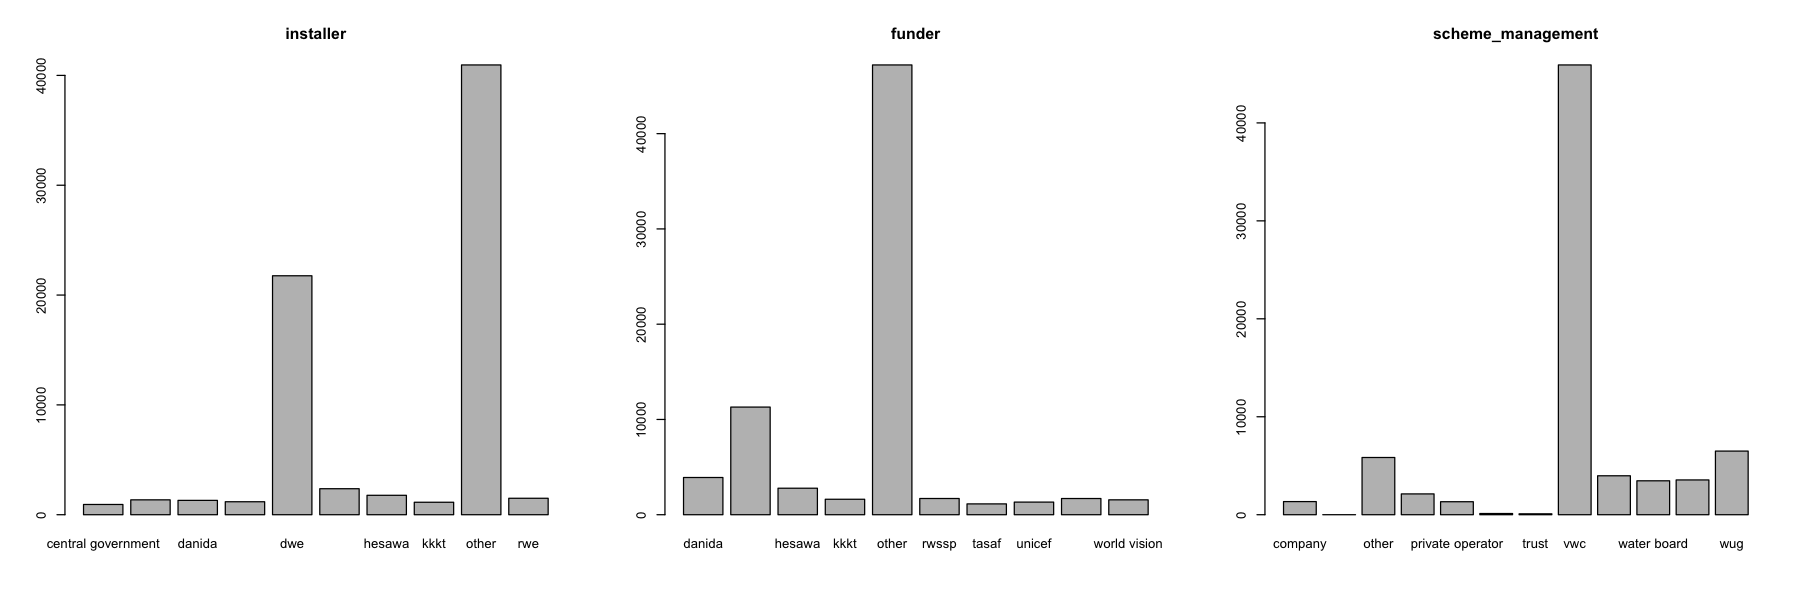

In [53]:
par(mfrow=c(1,3))
options(repr.plot.width = 15, repr.plot.height = 5)

plot(data$installer,main="installer")
plot(data$funder,main="funder")
plot(data$scheme_management,main="scheme_management")

### Redundant features


#### Redundant features are :
#### (quantity , quantity_group)
#### (payment , payment type)
#### (waterpoint_type , waterpoint_type_group)
#### (water_quality , quality_group)
#### (source , source_type , source_class) 
#### (management , management_group)
#### (extraction_type , extraction_type_group , extraction_type_class)



We removed redundant features. 
`quantity`and `quantity_group` are the same that is why we only keep quantity.

In [54]:
length(data$quantity_group[data$quantity_group==data$quantity])/nrow(data)

[1] 1

In [55]:
summary(train$payment_type)
summary(train$payment)

annually    monthly  never pay on failure      other per bucket    unknown 
      3642       8300      25348       3914       1054       8985       8157

never pay                 other          pay annually 
                25348                  1054                  3642 
          pay monthly        pay per bucket pay when scheme fails 
                 8300                  8985                  3914 
              unknown 
                 8157

`payment`and `payment_type` are the same (written differently) that is why we only keep payment

In [56]:
summary(train$waterpoint_type_group)
summary(train$waterpoint_type)

cattle trough communal standpipe                dam          hand pump 
               116              34625                  7              17488 
   improved spring              other 
               784               6380

cattle trough          communal standpipe 
                        116                       28522 
communal standpipe multiple                         dam 
                       6103                           7 
                  hand pump             improved spring 
                      17488                         784 
                      other 
                       6380

The `waterpoint_type_group` and the `waterpoint_type` variable variable share the same information, with the sole difference being the two standpipe groups have been summed together for the first one. We, therefore, decided to keep only the `waterpoint_type` variable.

In [57]:
summary(train$water_quality)
summary(train$quality_group)

coloured           fluoride fluoride abandoned              milky 
               490                200                 17                804 
             salty    salty abandoned               soft            unknown 
              4856                339              50818               1876

colored fluoride     good    milky    salty  unknown 
     490      217    50818      804     5195     1876

The `water_quality` and the `quality_group` variable share the same information. We decided to only keep the first feature.

In [58]:
summary(train$source)
summary(train$source_type)
summary(train$source_class)

dam             hand dtw                 lake 
                 656                  874                  765 
         machine dbh                other rainwater harvesting 
               11075                  212                 2295 
               river         shallow well               spring 
                9612                16824                17021 
             unknown 
                  66

borehole                  dam                other 
               11949                  656                  278 
rainwater harvesting           river/lake         shallow well 
                2295                10377                16824 
              spring 
               17021

groundwater     surface     unknown 
      45794       13328         278

The `source` , `source_class` and the `source_type` variable share the same information. We also kept only the first one.

In [59]:
summary(train$management)
summary(train$management_group)

company            other   other - school       parastatal 
             685              844               99             1768 
private operator            trust          unknown              vwc 
            1971               78              561            40507 
 water authority      water board              wua              wug 
             904             2933             2535             6515

commercial      other parastatal    unknown user-group 
      3638        943       1768        561      52490

The `management` and `management_group` share the same information.

In [60]:
summary(train$extraction_type)
summary(train$extraction_type_group)
summary(train$extraction_type_class)

afridev                      cemo                    climax 
                     1770                        90                        32 
                  gravity             india mark ii            india mark iii 
                    26780                      2400                        98 
                      ksb                      mono               nira/tanira 
                     1415                      2865                      8154 
                    other other - mkulima/shinyanga         other - play pump 
                     6430                         2                        85 
        other - rope pump            other - swn 81               submersible 
                      451                       229                      4764 
                   swn 80                    walimi                  windmill 
                     3670                        48                       117

afridev         gravity   india mark ii  india mark iii            mono 
           1770           26780            2400              98            2865 
    nira/tanira           other  other handpump other motorpump       rope pump 
           8154            6430             364             122             451 
    submersible          swn 80    wind-powered 
           6179            3670             117

gravity     handpump    motorpump        other    rope pump  submersible 
       26780        16456         2987         6430          451         6179 
wind-powered 
         117

The `extraction_type` ,`extraction_type_group`, `extraction_type_class` share the same information. We only kept the first feature.

In [61]:
Remove_redundant <- function(data) { 

    data=subset(data, select = -c(quantity_group,payment_type,waterpoint_type_group,quality_group,
                              source_type,source_class,management_group,extraction_type_group,
                              extraction_type_class))
    return(data)
}

train=Remove_redundant(train)
test=Remove_redundant(test)
data=Remove_redundant(data)

In [62]:
dim(train)
dim(test)
dim(data)

[1] 59400    21

[1] 14850    20

[1] 74250    20

## Missing values imputation 

In [63]:
summary(train$permit)
summary(train$public_meeting)

False  True 
 3056 17492 38852

False  True 
 3334  5055 51011

`permit` and `public_meeting` features take only TRUE or FALSE as answer but have a lot of missing values. We replaced the missing values by a third category called "unkown".

In [64]:
Replace_NA <- function (data) { #Replace by unkown 
    
    
    levels(data$permit)[levels(data$permit) %in%  c(" ", "","0", "_","-",NA)] <- "unknown"
    levels(data$public_meeting)[levels(data$public_meeting) %in%  c(" ", "","0", "_","-",NA)] <- "unkown"

    
    return(data)
}

train=Replace_NA(train)
test=Replace_NA(test)
data=Replace_NA(data)

We will now handle the missing values of the other categorical features.

In [65]:
fact = which(sapply(data[1, ], class) == "factor")
a=c(names(fact))
b=NULL
for (i in 1:length(c(names(fact)))){
   
    b=rbind(b,length(data[,a[i]][(data[,a[i]] %in% c(NA,0,""," ","-","_"))]))
    
    
}

missing_value_per_feature=cbind(a,b)
missing_value_per_feature

a,
funder,0
installer,0
basin,0
region,0
public_meeting,0
scheme_management,0
permit,0
extraction_type,0
management,0
payment,0


We are now done with data cleaning. Note that the feature : `basin` was not modified.

In [66]:
dim(train)
dim(test)
dim(data)

[1] 59400    21

[1] 14850    20

[1] 74250    20

### Transformation of categorical variables

In [67]:
dim(train)
dim(test)
dim(data)

[1] 59400    21

[1] 14850    20

[1] 74250    20

We identify all categorical variables.

In [68]:
fact = which(sapply(data[1, ], class) == "factor")
fact

funder         installer             basin            region 
                3                 5                 8                 9 
   public_meeting scheme_management            permit   extraction_type 
               11                12                13                14 
       management           payment     water_quality          quantity 
               15                16                17                18 
           source   waterpoint_type 
               19                20

We then created `data_fact` which contains all the data set with solely categorical variables.

In [69]:
data_fact = data[, fact]
data_numb = data[, -fact]

In [70]:
head(data_numb)

,amount_tsh,age,gps_height,longitude,latitude,population
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.000000,4770,0,33.12583,-5.118154,0.000000
2,0.000000,1159,1978,34.77072,-9.395642,3.044522
3,0.000000,4770,0,36.11506,-6.279268,0.000000
4,2.397895,5267,1639,37.14743,-3.187555,3.258097
5,0.000000,4770,0,36.16489,-6.099289,0.000000
6,3.931826,4770,28,39.28612,-6.972403,8.842604


We now transform categorical data so they can be used in the training using one-hot encoding. 


In [70]:
data_fact <- dummy.data.frame(data_fact, sep="_")

Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts ar

In [71]:
head(data_fact)

,funder_danida,funder_government of tanzania,funder_hesawa,funder_kkkt,funder_other,funder_rwssp,funder_tasaf,funder_unicef,funder_world bank,funder_world vision,⋯,source_shallow well,source_spring,source_unknown,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,0,0,0,0,0,1,0,0,0,⋯,1,0,0,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0,0,0,⋯,1,0,0,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,⋯,0,1,0,0,1,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,⋯,1,0,0,0,0,0,0,1,0,0
6,0,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,1,0,0,0,0


We then add again the numerical variables once one-hot encoding has been performed.

In [72]:
data_final <- cbind(data_fact, data_numb)

In [73]:
head(data_final)

,funder_danida,funder_government of tanzania,funder_hesawa,funder_kkkt,funder_other,funder_rwssp,funder_tasaf,funder_unicef,funder_world bank,funder_world vision,⋯,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,amount_tsh,age,gps_height,longitude,latitude,population
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,0,0,1,0,0,0,⋯,0,1,0,0,0.000000,4770,0,33.12583,-5.118154,0.000000
2,0,0,0,0,1,0,0,0,0,0,⋯,0,1,0,0,0.000000,1159,1978,34.77072,-9.395642,3.044522
3,0,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0.000000,4770,0,36.11506,-6.279268,0.000000
4,0,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,2.397895,5267,1639,37.14743,-3.187555,3.258097
5,0,0,0,0,1,0,0,0,0,0,⋯,0,1,0,0,0.000000,4770,0,36.16489,-6.099289,0.000000
6,0,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,3.931826,4770,28,39.28612,-6.972403,8.842604


In [74]:
nrow(data)==(nrow(test)+nrow(train))

[1] TRUE

In [75]:
final_train=data_final[1:nrow(train),]
final_test=data_final[(nrow(train)+1):nrow(data),]
if (nrow(final_train)==nrow(train) & nrow(final_test)==nrow(test)){
    print ("same size")
}

[1] "same size"


In [76]:
head(final_train)

,funder_danida,funder_government of tanzania,funder_hesawa,funder_kkkt,funder_other,funder_rwssp,funder_tasaf,funder_unicef,funder_world bank,funder_world vision,⋯,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,amount_tsh,age,gps_height,longitude,latitude,population
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,0,0,1,0,0,0,⋯,0,1,0,0,0.000000,4770,0,33.12583,-5.118154,0.000000
2,0,0,0,0,1,0,0,0,0,0,⋯,0,1,0,0,0.000000,1159,1978,34.77072,-9.395642,3.044522
3,0,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0.000000,4770,0,36.11506,-6.279268,0.000000
4,0,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,2.397895,5267,1639,37.14743,-3.187555,3.258097
5,0,0,0,0,1,0,0,0,0,0,⋯,0,1,0,0,0.000000,4770,0,36.16489,-6.099289,0.000000
6,0,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,3.931826,4770,28,39.28612,-6.972403,8.842604


In [77]:
test_init <- read.csv("Test set values.csv", header = TRUE)

We are now done with the data cleaning and data processing part. final_train contains our training set. Y contains the results for the training set and final_test contains the data that we need to predict. We also create a test_init data set that will serve for tracking the ids of the samples.

# Model selection

## Model 1 : Logistic regression

We decided to start with logistic regression as it is relatively easy to interpret, and very efficient to train. We perform a tuning of the parameters $\alpha$ and $\lambda$, where we apply a 10 fold cross-validation and use the misclassification error to find the $\alpha$ that gives that minimises it. <br>

We set the values for $\alpha$ in the range from 0 to 1 with a step of 0.1 before we run the loop over these values.

In [ ]:
alpha_opt=NULL
alpha=seq(0,1,0.1)


for (i in 1:length(alpha)){
    cv_fit <- cv.glmnet(as.matrix(final_train),
                   Y,
                   nfolds = 10,
                   type.measure = "class",
                   alpha = alpha[i],
                   grouped = FALSE,
                   family = "multinomial")
    
    a=cv_fit$index[1]
    alpha_opt=cbind(alpha_opt,cv_fit$cvm[a])
    
}

In [2]:
alpha

[1] 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0

In [89]:
which.min(alpha_opt)

[1] 2

We can see that the value of $\alpha$ giving the smallest misclassification error is the one with index 2 in the sequence of its values introduced earlier, i.e.,  $\alpha$ = 0.1

We now build a model on 100 lambda values based on the $\alpha$ that minimises the misclassification:


In [166]:
cv_fit <- cv.glmnet(as.matrix(final_train),
                   Y,
                   nfolds = 10,
                   type.measure = "class",
                   alpha = alpha[which.min(alpha_opt)],
                   grouped = FALSE,
                   family = "multinomial")

In [167]:
fit_lasso <- glmnet(as.matrix(final_train),
              Y,
              alpha = alpha[which.min(alpha_opt)],
              family = "multinomial")

In [92]:
cv_fit$lambda.min

[1] 0.0003191425

The previous cell indicates the value of $\lambda$ that gives the minimum cross-validated error. <br>
And so we now can predict using $\lambda$ with lowest error in the 10-fold cross validation.

In [168]:
prediction_lasso<-predict(fit_lasso, as.matrix(final_test), s = cv_fit$lambda.min, type = "class")

In [170]:
table(prediction_lasso)

prediction_lasso
   0    1    2 
9965 4728  157 

In [95]:
for (i in 1:length(prediction_lasso)){
    if (prediction_lasso[i]==0){
        prediction_lasso[i]="functional"
    } else if (prediction_lasso[i]==1){
        prediction_lasso[i]="non functional"
        
    } else {

        prediction_lasso[i]="functional needs repair"        
    }
}

head(prediction_lasso)

1
functional
functional
non functional
non functional
functional
functional


In [96]:
final_lasso<-as.data.frame(cbind(test_init$id,prediction_lasso))
names(final_lasso)[1]<-paste("id")
names(final_lasso)[2]<-paste("status_group")
head(final_lasso)

,id,status_group
,<chr>,<chr>
1,50785,functional
2,51630,functional
3,17168,non functional
4,45559,non functional
5,49871,functional
6,52449,functional


We can now import the prediction results of our model on the testing data as a csv.

In [97]:
write.csv(final_lasso, file = "lassomodel_optimal.csv",row.names=F)

Accuracy: 0.7407 <br>
This is an acceptable accuracy for our logistic regression model, but we will compare it to other models later on before drawing any conclusions. We will also use another library (caret) to see if the accuracy improves or not.

## Model 1 bis : Logistic regression Logistic regression using caret library.

For comparison, we decided to develop and apply a (second) logistic regression through the caret library to see how it performs compared to what we did earlier. <br>
We perform a 10 fold cross-validation and create a grid for $\alpha$ and $\lambda$ values to tune and find the best parameters.

In [98]:
tr_ctrl <- caret::trainControl(method = "cv", number = 10)

In [99]:
hyperparams <- expand.grid(lambda = c(seq(0, 0.001, 0.0001)), alpha = seq(0, 0.1, 0.01))

In [100]:
cv_models <- caret::train(x = final_train,
                          y = Y,
                          family = "gaussian",
                          metric = "RMSE",
                          method = "glmnet",
                          trControl = tr_ctrl,
                          tuneGrid = hyperparams)

We can now print the best parameters.

In [101]:
best_tune <- cv_models$bestTune
best_tune

,alpha,lambda
,<dbl>,<dbl>
61,0.05,5e-04


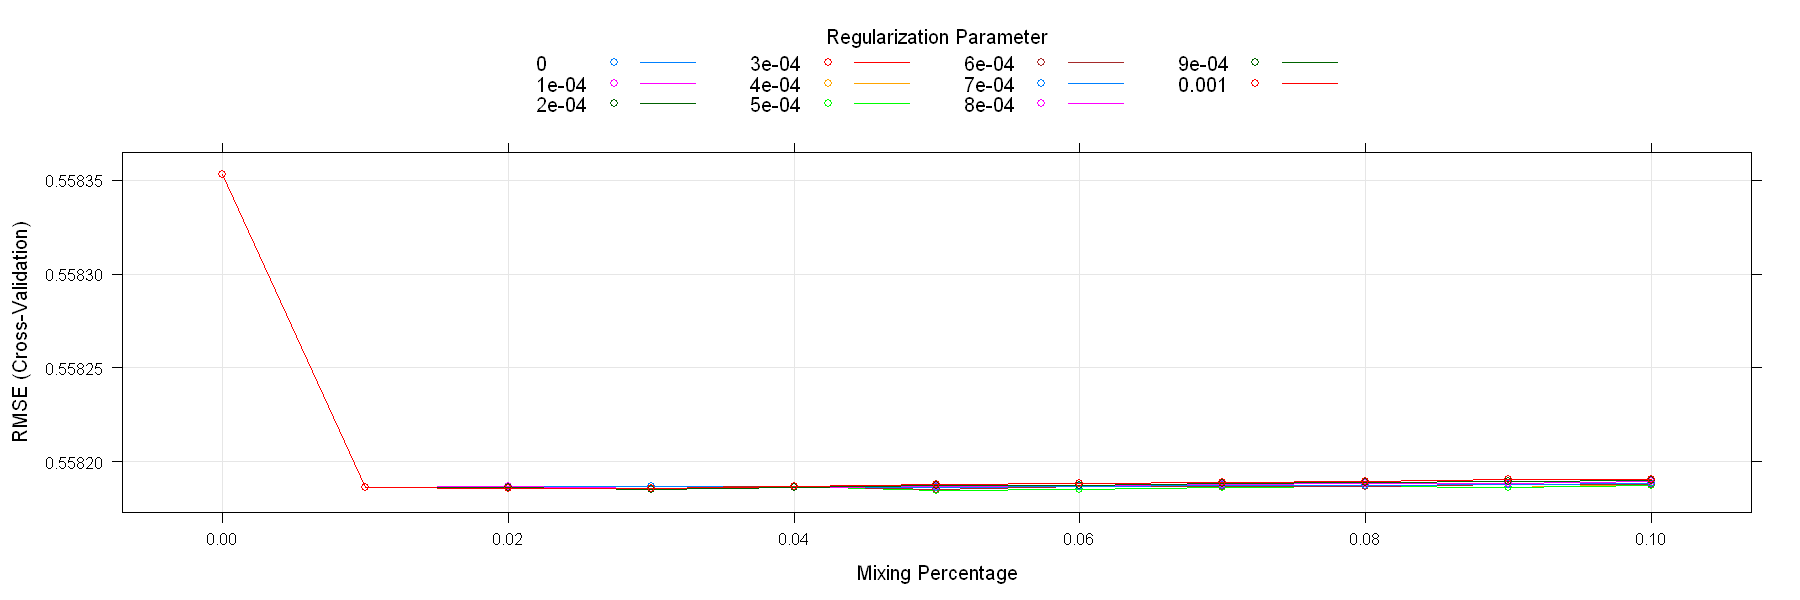

In [102]:
plot(cv_models)

Using the tuned/best parameters, we create the optimised model and use it to predict the testing set.

In [160]:
final_model <- glmnet::glmnet(x = as.matrix(final_train), 
                              y = Y, 
                              family = "multinomial", 
                              alpha = best_tune[1],
                              lambda = best_tune[2])

In [161]:
prediction_lasso_caret<-predict(final_model,data.matrix(final_test),s =  best_tune[2], type = "class")

In [165]:
table(prediction_lasso_caret)

prediction_lasso_caret
   0    1    2 
9968 4725  157 

In [107]:
for (i in 1:length(prediction_lasso_caret)){
    if (prediction_lasso_caret[i]==0){
        prediction_lasso_caret[i]="functional"
    } else if (prediction_lasso_caret[i]==1){
        prediction_lasso_caret[i]="non functional"
        
    } else {

        prediction_lasso_caret[i]="functional needs repair"        
    }
}

head(prediction_lasso_caret)

1
functional
functional
non functional
non functional
functional
functional


In [108]:
prediction_lasso_caret<-as.data.frame(cbind(test_init$id,prediction_lasso_caret))
names(prediction_lasso_caret)[1]<-paste("id")
names(prediction_lasso_caret)[2]<-paste("status_group")
head(prediction_lasso_caret)

,id,status_group
,<chr>,<chr>
1,50785,functional
2,51630,functional
3,17168,non functional
4,45559,non functional
5,49871,functional
6,52449,functional


In [109]:
write.csv(prediction_lasso_caret, file = "lassomodel_caret_library.csv",row.names=F)

Acuracy of 0.7409.

Using the second library, results are slightly better but the difference is not considerable. So using the first method or the second one gives practically the same results.

## Model 2 : random forest

We now use a random forest model, as it is known for working well with both categorical and continuous values while it reduces the overfitting compared to other models (e.g., decision trees). This makes it a good choice for this project considering the dataset we have and the problem in hand.<br>

We did perform here an hyperparametrisation on the number of trees in the random forest to find the optimal one. For performance reasons and to have a reasonable running time for this code, considering the limited computing power we pocess, we will take three values for the number of trees: 100, 1000 and 2500. We tried several different values and decided to only keep these three as they show that multiplying the number of trees by 10 or 2,5 does not have an impact of the same magnitude on accuracy (while it still have a similar impact on the running time on the other hand).

In [110]:
target_variable <- ncol(final_train)
number_of_trees=c(100,1000,2500)

for (i in 1:length(number_of_trees)){
    model_forest <- randomForest(x=final_train,
                                 y=(as.factor(Y)),
                                 ntree=number_of_trees[i])

    confusion_matrix=model_forest$confusion
    accuracy = (confusion_matrix[1,1]+confusion_matrix[2,2]+confusion_matrix[3,3])/sum(confusion_matrix)

    print(paste("[INFO] - Accuracy -",number_of_trees[i],"trees :",accuracy)) }

[1] "[INFO] - Accuracy - 100 trees : 0.804446534504489"
[1] "[INFO] - Accuracy - 1000 trees : 0.807712639898345"
[1] "[INFO] - Accuracy - 2500 trees : 0.807561147725947"


One can see that using 1000 trees instead of 100 improves the accuracy by merely 0.33%, which, considering the increase in the run time, is not a good trade-off between performance and duration.<br>
Moreover, going from 1000 trees to 2500 decreased the accuracy (a very low dip in fact but it is still a dip), which can be explained by a possible overfitting of the model.<br>

We decided to keep the model with 1000 trees as it has the highest accuracy and a reasonable running time, which is a god trade-off in our opinion.

## Random forest 1000 trees

In [124]:
model_forest_1000trees <- randomForest(x=final_train,
                                 y=as.factor(as.factor(Y)),
                                 ntree=1000)

In [125]:
confusion_matrix=model_forest_1000trees$confusion
accuracy = (confusion_matrix[1,1]+confusion_matrix[2,2]+confusion_matrix[3,3])/sum(confusion_matrix)
accuracy

[1] 0.8078305

One useful feature in the random forest is that it allows us to easily find the most important features in our dataset, which makes the interpretation and the understanding of the problem easier.<br>

We use the gini impurity criterion instead of entropy as it is better for selecting important features.<br>

We plot the most important features given by the random forst model with 1000 trees:

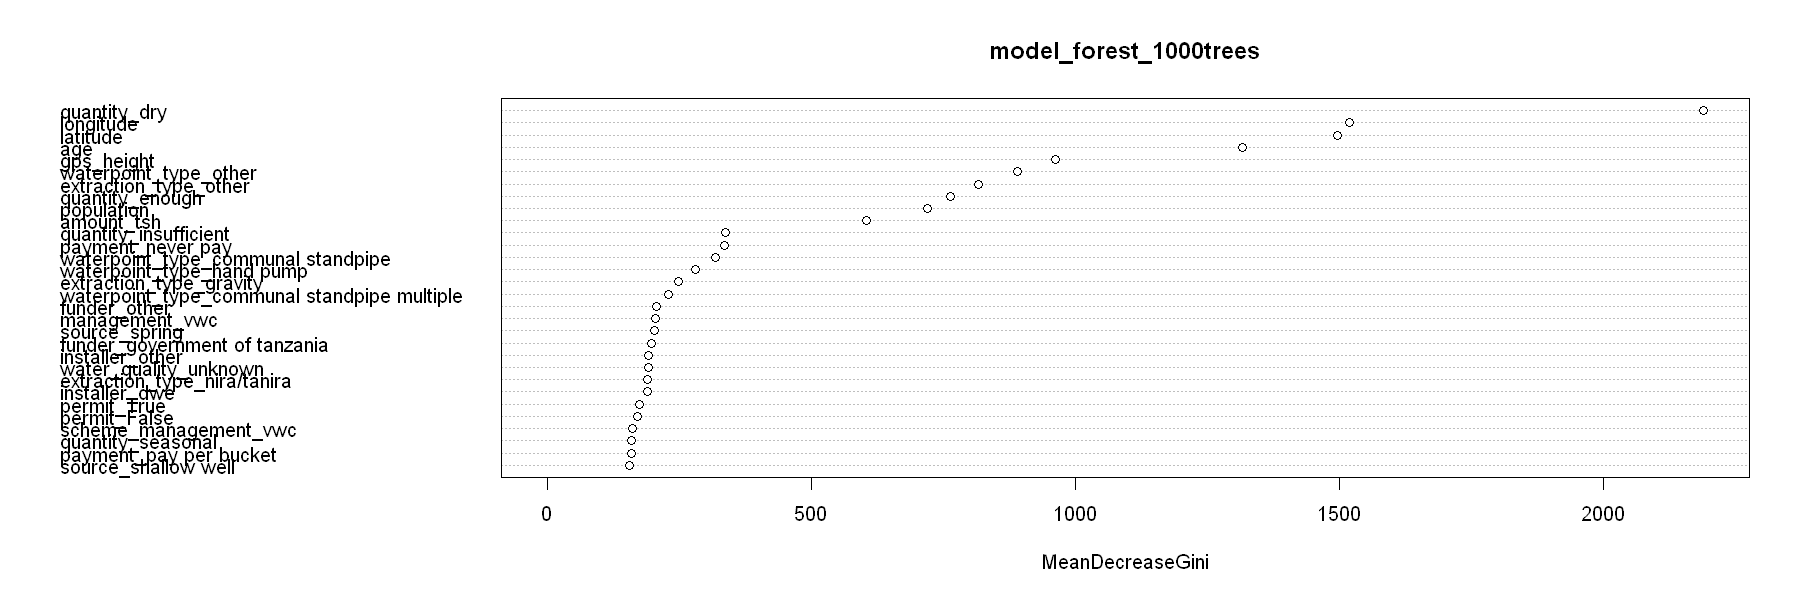

In [126]:
varImpPlot(model_forest_1000trees)

We see that if the water pump is dry, it is a strong indicator that a reparation is needed (i.e., it is either not functioning or need reparation). We notice also that the location variables of the water pumps (longitude, latitude, and gps height) are also very important in knowing its state and if we need to intervene for a reparation or not. Additionally, the age of the pump is also a good indicator of its state.<br>

Nothing is really surprising from these results, as we can see that not all the geographic zones and regions enjoy the same level of development and access to easy maintenance of the pumps. Furthermore, old pumps in our dataset are logically more prone to issues and malfunction; this is applicable to all industrial machinery no matter the domain or the country.<br>

We would also like to add that a few variables are way more important than the others in this case of predicting the necessity of needing a reparation, which means that focusing and prioritizing these features over the other ones when tackling the problem will result in the best "payoff/effort" ratio.<br>

Now we can apply our model to the test set and export the predictions as a csv so we can upload it to the competition.

In [127]:
predict_forest_1000trees=predict(model_forest_1000trees, final_test)

In [128]:
predict_forest_1000trees <-data.frame(id=test_init$id,status_group=predict_forest_1000trees)

In [129]:
head(predict_forest_1000trees)

,id,status_group
,<int>,<fct>
59401,50785,0
59402,51630,0
59403,17168,0
59404,45559,1
59405,49871,0
59406,52449,0


In [130]:
predict_forest_1000trees  <- ifelse(predict_forest_1000trees$status_group == 0, "functional", ifelse(predict_forest_1000trees$status_group == 1,"non functional", "functional needs repair"))

In [131]:
predict_forest_1000trees<-as.data.frame(cbind(test_init$id,predict_forest_1000trees))
names(predict_forest_1000trees)[1]<-paste("id")
names(predict_forest_1000trees)[2]<-paste("status_group")

head(predict_forest_1000trees)

,id,status_group
,<chr>,<chr>
1,50785,functional
2,51630,functional
3,17168,functional
4,45559,non functional
5,49871,functional
6,52449,functional


In [132]:
write.csv(predict_forest_1000trees, file = "predict_forest_1000trees.csv",row.names=F)

Accuracy de 0.8078.

We kept the random forest with 1000 trees as it has the highest accuracy. Notice the considerable difference and improvement in results between what was given by the random forest model compared to the logistic regression earlier results. This second model also took us less times to run and execute compared to the logistic regression.

### Random forest et PCA

Since we have a long list of features in our dataset and considering the long running time we faced above, one might think that some variables might be strongly correlated and we could reduce the dimensioniality of the data while increasing the efficiency of our model using statistical techniques.<br>

As such, we decided to use the **Principal Component Analysis (PCA)** as a features engineering tool to see if it helps improving the results while reducing computation costs.

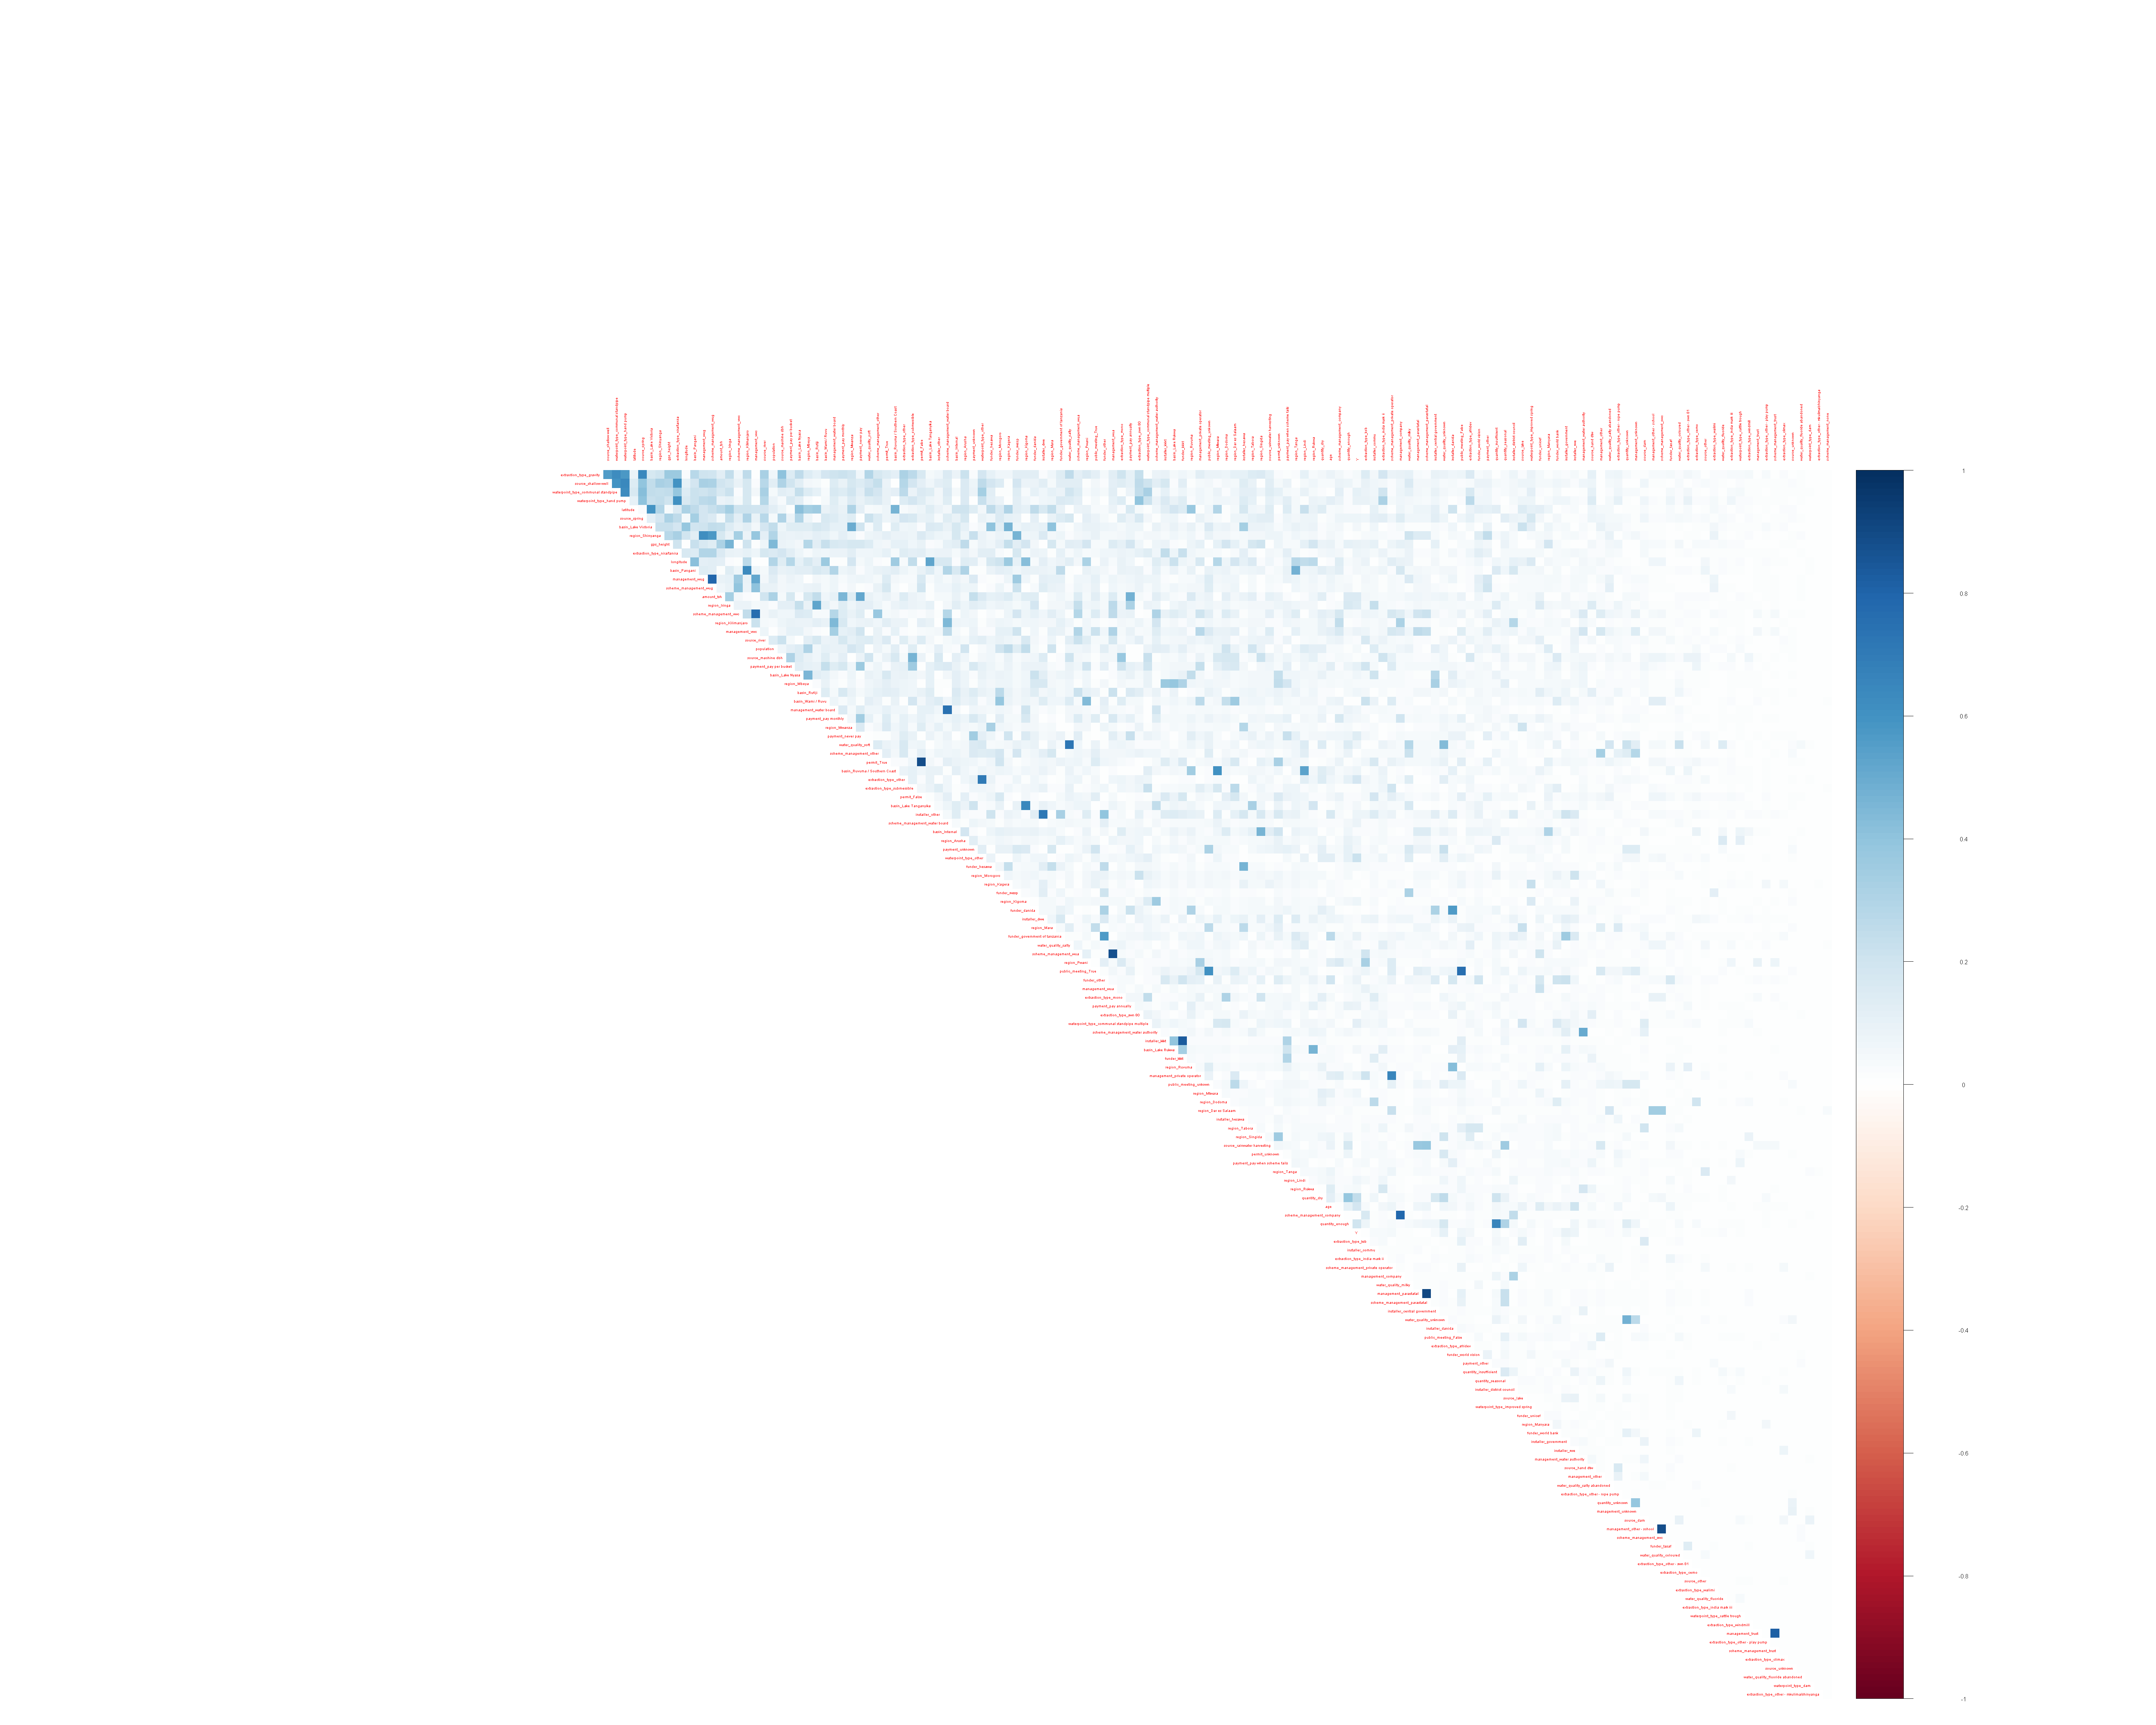

In [133]:
options(repr.plot.width = 50, repr.plot.height = 40)
training_explore<-cbind(final_train,Y)
training_explore$Y<-as.numeric(training_explore$Y)
cor_matrix<-abs(cor(training_explore))
diag(cor_matrix)<-0
corrplot(cor_matrix, diag = FALSE, order = "FPC",
         tl.pos = "td", tl.cex = 0.5, method = "color", type = "upper")

In [134]:
prComp<-prcomp(final_train,scale. = TRUE)

In [135]:
std_dev <- prComp$sdev
pr_var <- std_dev^2
prop_varex <- pr_var/sum(pr_var)
sum(prop_varex[1:100])

[1] 0.9679795

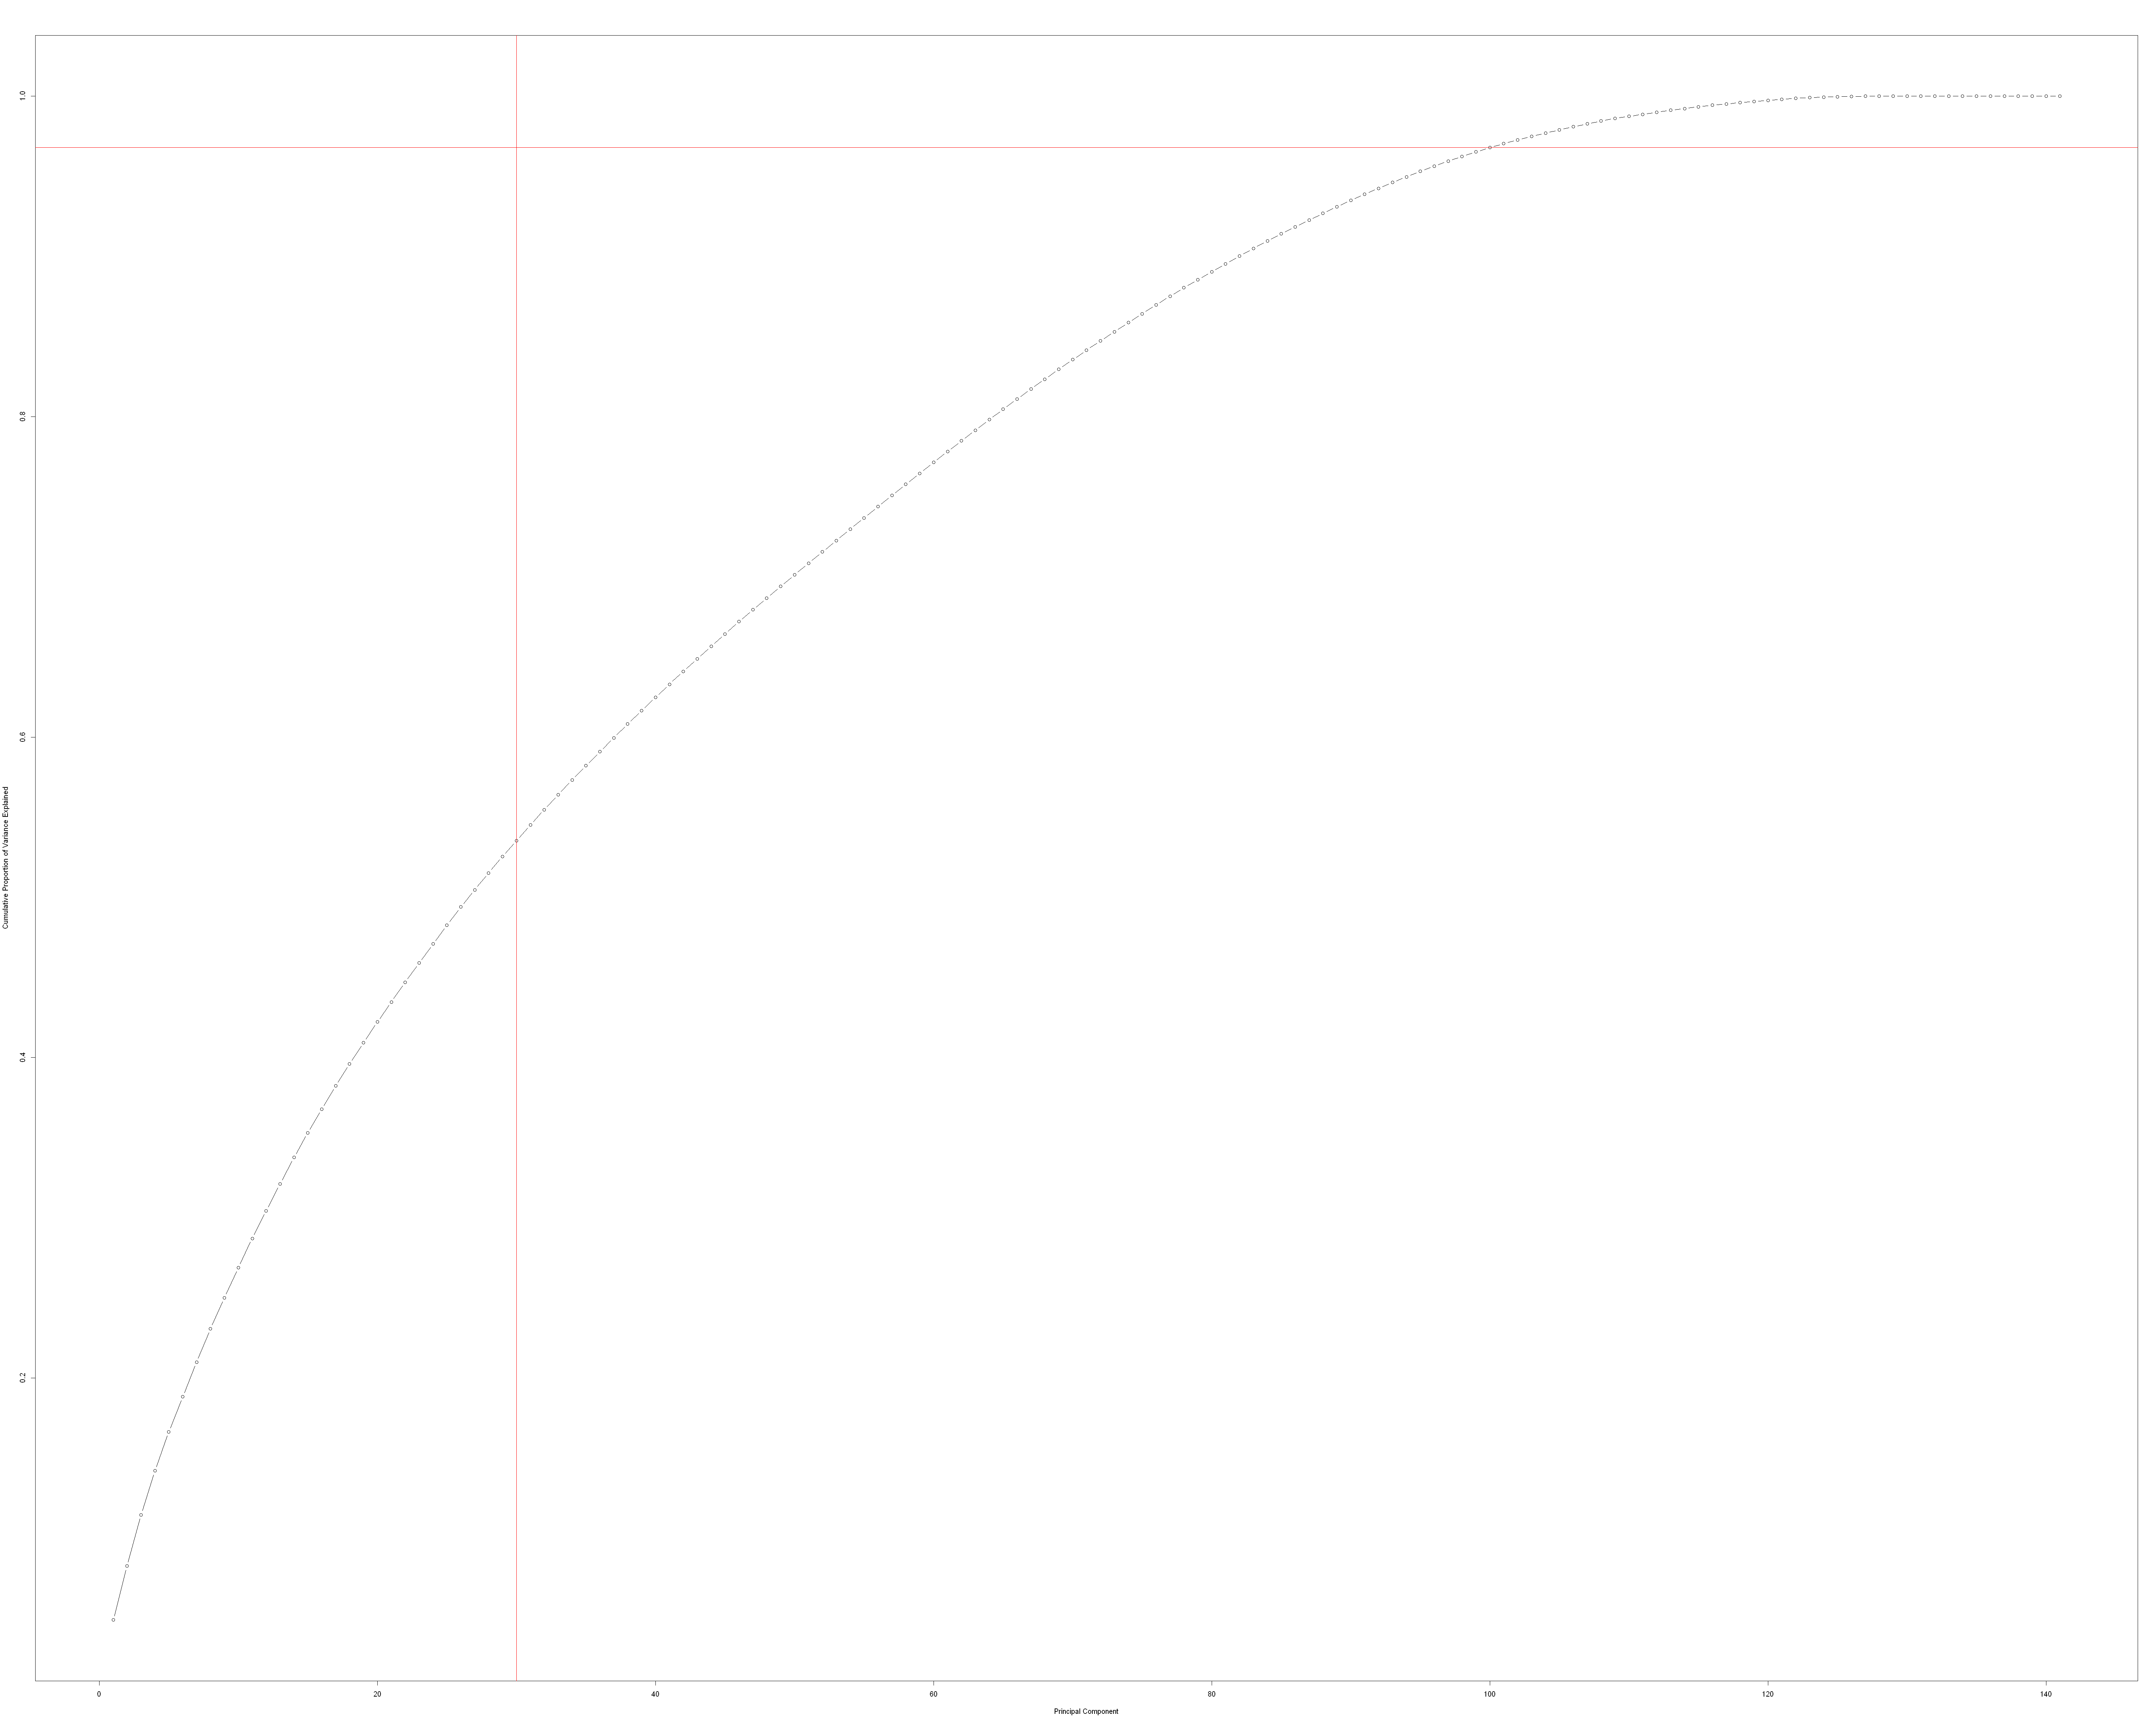

In [136]:
plot(cumsum(prop_varex), xlab = "Principal Component",ylab = "Cumulative Proportion of Variance Explained",type = "b")

abline(h=0.96797,col='red',v=30)


From the results above, we see that 100 Principal Components explain about 96.8 % of the total variance. So by using PCA, the dimensions can be reduced from 140 to 100, which means and decrease by around 29% of the variables used, while dropping only 3.2% of the variance. This is a trade-off that we can live with since it seems benefical overall. 


In [137]:
train.data<-data.frame(classe = Y, prComp$x)
train.data <- train.data[,1:101]

In [138]:
head(train.data)

,classe,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,-4.0844941,0.17039126,0.3634385,-0.04016491,0.14671006,2.5483235,-0.3293843,-1.86318331,-1.2106501,...,-1.07996942,0.2305213,-0.4801658,-0.2265992,0.43209695,0.5064264,-1.9029735,0.5395774,0.709485828,1.35238819
2,0,-0.8883726,0.08862643,1.1126713,2.44032647,1.50579176,0.8212693,0.5745947,1.53769775,1.7573276,...,-0.50992672,-0.1093666,0.7019614,0.5900657,1.21453508,-1.0536291,0.2370084,-0.7330755,-0.656888862,0.63420334
3,0,0.2376733,4.10886154,0.8750183,-2.09790950,-0.08992059,-0.8313201,2.4817251,-0.42921314,-0.2061543,...,-0.51747904,0.4580271,1.0477444,-0.8877595,-0.57197878,-0.4072760,-0.5272480,-1.0051430,0.057598886,0.76180215
4,0,3.9751145,-0.37466822,-4.7554505,-0.24359635,0.17208149,-2.1802262,-0.1791345,-2.08016224,0.1309372,...,-0.54835908,0.3835413,-0.2004273,-0.2241427,-0.01536391,0.2111686,0.1428424,0.1030046,-0.008919525,-0.03891996
5,1,-2.0018542,1.43722904,1.5842291,-0.64492744,0.15293014,-0.8144660,0.7505204,-0.04218295,1.2675560,...,-0.08676647,-0.7476654,1.2215401,-0.4081284,-0.13245585,-1.1482044,-0.1030241,0.2453962,-0.390975928,0.52688018
6,0,0.6955926,7.68556153,-1.9518540,2.06832777,0.09301661,-2.1319639,2.1335707,1.19314725,-3.5036559,...,-0.68930513,-0.6794636,-0.9217924,-0.7067374,-0.15295818,0.6453302,-0.3732001,0.4994787,0.092495006,0.06830612


Since the random forest gave us the best accuracy, we will combine it with the PCA and see how the performance changes. Note that we keep the same number of trees as before.

In [139]:
model_forest_pca <- randomForest(x=train.data[,2:ncol(train.data)],
                          y=as.factor(train.data$classe),
                          ntree=1000, seed = 123456)

In [140]:
test.data<-predict(prComp, newdata = final_test)
test.data <- as.data.frame(test.data)
test.data <- test.data[,1:100]
pred_test <- predict(model_forest_pca, test.data)
head(pred_test)

59401 59402 59403 59404 59405 59406 
    0     0     0     1     0     0 
Levels: 0 1 2

In [146]:
confusion_matrix=model_forest_pca$confusion
accuracy = (confusion_matrix[1,1]+confusion_matrix[2,2]+confusion_matrix[3,3])/sum(confusion_matrix)
accuracy

[1] 0.7883365

In [141]:
pred_test=data.matrix(pred_test)
pred_test=as.numeric(pred_test)
head(pred_test)

[1] 0 0 0 1 0 0

In [142]:
for (i in 1:length(pred_test)){
    if (pred_test[i]==0){
        pred_test[i]="functional"
    } else if (pred_test[i]==1){
        pred_test[i]="non functional"
        
    } else {

        pred_test[i]="functional needs repair"        
    }
}

head(pred_test)

[1] "functional"     "functional"     "functional"     "non functional"
[5] "functional"     "functional"

In [144]:
final_randomforest_pca <-as.data.frame(cbind(test_init$id,pred_test))
names(final_randomforest_pca)[1]<-paste("id")
names(final_randomforest_pca)[2]<-paste("status_group")
head(final_randomforest_pca)


,id,status_group
,<chr>,<chr>
1,50785,functional
2,51630,functional
3,17168,functional
4,45559,non functional
5,49871,functional
6,52449,functional


In [145]:
write.csv(final_randomforest_pca, file = "final_randomforest_pca.csv",row.names=F)


Accuracy de 0.7883.

As we can see when comparing the two accuracy rates, PCA doesn't improve the results. This can be due to the fact that the 3.2% "dropped" from the total variance when applying the PCA plays an important role in our data set and is crucial for our model to perform well.

# Model 3: Neural Network

Let's make a quick reminder. Neural networks are part of machine learning and play a major role in deep learning. Their structure is inspired by the structure of how a human brain works, copying tha way neurons work with each other. 

Neural Networks are composed by layers. An input layer, one/many hidden layers and an output layer.
When an input layer is determined, weights are assigned. These weights represent the importance of the variables, with larger ones contributing more significantly to the output compared to other inputs. 
All inputs are s!ummed accoring to their weights. Afterward, the output of the first layer is passed through an activation function,the hidden layers, which determines the output.


To build and use the neural network model, we must install the package and the library nnet for this project.


Sources: 

G. Bontempi, "Statistical foundations of machine learning", Computer Science Department ULB, Université Libre de Bruxelles, Belgium, Second edition.
https://www.ibm.com/cloud/learn/neural-networks#toc-what-are-n-2oQ5Vepe

We will use the model_one_hot neural network since our dataset present 3 different outputs:

functional - non functional - functional needs repair.

#### Cross validation and hyper-parametrisation

To evaluate the model accuracy and validate it, we made a k-fold validation. 
We also did here a hyper parametrisation to test several number of nodes.
We chose to split it 2 folds. The reason of that decision was to make sure that the neural network performed as well as possible. Indeed, according to AnalyticsInsights, neural networks perform better when there is a lot of data and thus we opted for folders containing more data.

Sources: 
- https://www.analyticsinsight.net/neural-networks-not-answer-everything/
- https://stats.stackexchange.com/questions/61090/how-to-split-a-data-set-to-do-10-fold-cross-validation 

Also, we are directly testing our neural network model with 10 nodes in order to try to avoid issues with the confusion matrix.
Since we use the nnet package, we only test neural networks with a single hidden layer.

Source: 
https://cran.r-project.org/web/packages/nnet/nnet.pdf

In [76]:
numberFolds <- 2
number_of_nodes=c(10,15,20,35)
threshold <- 0.5

# generate array containing fold-number for each sample (row)
folds <- rep_len(1:numberFolds, nrow(final_train))

# actual cross validation
for(i in 1:numberFolds) {
    # actual split of the data
    fold <- which(folds == i)
    data.train <- final_train[-fold,]
    Y.train <- as.matrix(Y)[-fold,]
    data.test <- final_train[fold,]
    Y.test <- as.matrix(Y)[fold,]
    print(paste("[INFO] -  training set size", dim(data.train)[1], "-  testing set size", dim(data.test)[1]))

    # train and test our model with data.train and data.test
    
    for (j in 1:length(number_of_nodes)){
    
        #model in sample with data.train
    
        modelin <- nnet(x=data.train, y= class.ind(as.factor(Y.train)),size=number_of_nodes[j],
                        skip=FALSE,Trace=FALSE,maxit=3000,MaxNWts=100000, rang=0.2)
        Y_predin <- predict(modelin,data.train)
        Y_hatin <-ifelse(Y_predin[,1]>threshold, '0',ifelse(Y_predin[,2]>threshold,'1','2'))
        
        #accuracy in training sample
        confusion=table(Y_hatin,as.numeric(Y.train))
        print(confusion)
        accuracy = (confusion[1,1]+confusion[2,2]+confusion[3,3])/sum(confusion)
        print(paste("[INFO] -  Training set size", dim(data.train)[1], "-  Testing set size", dim(data.test)[1]))
        print(paste("[INFO] - Accuracy in sample for", number_of_nodes[j],"nodes :",accuracy))
    
        #model out sample with data.test
        modelout <- nnet(x=data.test, y= class.ind(as.factor(Y.test)),size=number_of_nodes[j],
                         skip=FALSE,Trace=FALSE,maxit=3000,MaxNWts=100000, rang=0.2)
        Y_predout<-predict(modelout,data.test)
        Y_hatout<-ifelse(Y_predout[,1]>threshold, '0',ifelse(Y_predout[,2]>threshold,'1','2'))
    
    
        #accuracy out sample testing set
        confusion=table(Y_hatout,as.numeric(Y.test))
        print(confusion)
        accuracy = (confusion[1,1]+confusion[2,2]+confusion[3,3])/sum(confusion)
        print(paste("[INFO] - Accuracy out sample for", number_of_nodes[j],"nodes :",accuracy))
}}

[1] "[INFO] -  training set size 29700 -  testing set size 29700"
# weights:  1453
initial  value 22020.977509 
iter  10 value 16595.973270
iter  20 value 16228.279493
iter  30 value 16138.882239
iter  40 value 16116.972128
iter  50 value 16113.605583
iter  60 value 16035.887759
iter  70 value 16033.053753
iter  80 value 15994.472267
iter  90 value 15979.332619
iter 100 value 15840.641112
iter 110 value 15816.180119
iter 120 value 15807.321845
iter 130 value 15700.005327
iter 140 value 15648.572807
iter 150 value 14794.843424
iter 160 value 12999.261088
iter 170 value 12221.845992
iter 180 value 11978.644790
iter 190 value 11842.559118
iter 200 value 11765.985315
iter 210 value 11724.306136
iter 220 value 11703.518980
iter 230 value 11683.821977
iter 240 value 11667.999905
iter 250 value 11655.249092
iter 260 value 11650.771244
iter 270 value 11648.942193
iter 280 value 11644.664081
iter 290 value 11637.607965
iter 300 value 11634.039514
iter 310 value 11631.838359
iter 320 value 11630

initial  value 18462.974318 
iter  10 value 15949.349089
iter  20 value 15817.078096
iter  30 value 15653.516874
iter  40 value 15602.615651
iter  50 value 15496.438642
iter  60 value 14822.317878
iter  70 value 13719.372195
iter  80 value 12836.551097
iter  90 value 12091.096846
iter 100 value 11700.859883
iter 110 value 11475.088919
iter 120 value 11313.904854
iter 130 value 11255.197094
iter 140 value 11184.340255
iter 150 value 11150.397513
iter 160 value 11099.847808
iter 170 value 11041.377950
iter 180 value 11037.996211
iter 190 value 11021.210293
iter 200 value 11009.999424
iter 210 value 10990.869766
iter 220 value 10969.486761
iter 230 value 10889.525126
iter 240 value 10796.202205
iter 250 value 10727.701600
iter 260 value 10684.058903
iter 270 value 10635.686684
iter 280 value 10589.740824
iter 290 value 10555.407450
iter 300 value 10529.788140
iter 310 value 10513.410941
iter 320 value 10492.825986
iter 330 value 10477.679266
iter 340 value 10466.529550
iter 350 value 1045

initial  value 22366.210581 
iter  10 value 15917.595643
iter  20 value 15778.916638
iter  30 value 15732.057392
iter  40 value 15697.516866
iter  50 value 15687.669933
iter  60 value 15670.713330
iter  70 value 15649.968454
iter  80 value 15613.576424
iter  90 value 15507.549305
iter 100 value 15363.349916
iter 110 value 15270.648215
iter 120 value 14998.577306
iter 130 value 14585.049059
iter 140 value 13980.232267
iter 150 value 12827.978572
iter 160 value 11984.449159
iter 170 value 11432.529629
iter 180 value 11111.932139
iter 190 value 10932.201309
iter 200 value 10805.002844
iter 210 value 10710.431058
iter 220 value 10642.152669
iter 230 value 10610.676891
iter 240 value 10608.523992
iter 250 value 10607.953300
iter 260 value 10606.803454
iter 270 value 10603.768963
iter 280 value 10594.709231
iter 290 value 10579.353531
iter 300 value 10555.457221
iter 310 value 10534.523758
iter 320 value 10506.177548
iter 330 value 10485.957829
iter 340 value 10460.581818
iter 350 value 1045

initial  value 18605.955379 
iter  10 value 15984.072040
iter  20 value 15868.977898
iter  30 value 15774.558175
iter  40 value 15490.154223
iter  50 value 15065.749906
iter  60 value 14465.419699
iter  70 value 13251.529781
iter  80 value 12891.603407
iter  90 value 12369.041788
iter 100 value 11890.352860
iter 110 value 11411.744965
iter 120 value 11199.245838
iter 130 value 11108.995349
iter 140 value 11057.733276
iter 150 value 10993.720587
iter 160 value 10937.793167
iter 170 value 10901.649648
iter 180 value 10869.610402
iter 190 value 10825.612715
iter 200 value 10797.268060
iter 210 value 10778.911057
iter 220 value 10764.074377
iter 230 value 10753.692115
iter 240 value 10744.853581
iter 250 value 10732.210963
iter 260 value 10667.871844
iter 270 value 10644.489335
iter 280 value 10633.790699
iter 290 value 10619.805403
iter 300 value 10597.819351
iter 310 value 10581.190637
iter 320 value 10567.038836
iter 330 value 10553.394399
iter 340 value 10543.796459
iter 350 value 1053

Here, we first settled the number of folds into which we decided to divide final_train, the number of nodes we wanted to test and the threshold. 


We also generate array containing fold-number for each row. 
Then we proceeded to the cross validation. 
We divided the set into 2 parts, on the one hand, the train set and the output corresponding to that at the row that equals to "folds" and on the other hand the test set and the output who contained the rest of the set. 

We also modified the class of Y into the matrix type to be able to split it correctly.

Let us briefly explain some aspects of the model in/out sample.

modelin <- nnet(x=data.train, y= class.ind(as.factor(Y.train)),size=number_of_nodes[j],
                        skip=FALSE,Trace=FALSE,maxit=3000,MaxNWts=100000, rang=0.2)


x = data.train correponds to the data we are using.

y= class.ind(as.factor(Y.train)) is more tricky.
Since the output needs to be a factor, we had to change its class to  factor and we used "as.factor" to do so.
Moreover, we have 3 outputs: functional - non functional - functional needs repair.
class.ind function gives us the opportunity to have these three outputs expressed as follows:
functional (1,0,0) - non functional (0,1,0) - functional needs repair (0,0,1).

the size is the number of nodes we are using.

skip= FALSE forbids the model to skip the hidden layer.

Maxit corresponds to the maximum iterations, we randomly settled it to 3000.

MawNWts allow us to change the maximum weights the model supports. By default it equals to 1000. We modified it to 100000 to have the possibility to test our model with a lot of hidden nodes.

Sources: 

-https://cran.r-project.org/web/packages/nnet/nnet.pdf <br>
-Practical session 4, J. De Stefani

Y_predin <- predict(modelin,data.train)
Y_hatin <-ifelse(Y_predin[,1]>threshold, '0',ifelse(Y_predin[,2]>threshold,'1','2'))

Y_predin will be the prediction R can make on the data.train with modelin and will give back the probabilities for each waterpoint contained in the set to belong to one class (functional - non functional - functional needs repair)

Source: 

https://www.rdocumentation.org/packages/twidlr/versions/0.0.0.9000/topics/lm

Y_hat will show these predictions in a clearer way. If the probability in the first column is higher than 50% then the waterpoint is functional if it's higher in than 50% in the second column, the waterpoint is non functional and else it will be considered as functional needs repair.



Then, we built a confusion matrix with the real output Y and the predicted output Y_hat to determine the accuracy of the model in and out the training set with the function table(Y_hatin,Y.train) and table(Y_hatout,Y.test)

At the end of the day, even if the resultats vary a lot, the neural network model with 10 nodes was the most accurate model in general, with 72,37% of accuracy in sample and 74,38% of accuracy out sample when we check the average of the two folds results.

Moreover, it is also important to take into account that according to articles in AnalyticsInsight and as we saw during the practical related to neural networks, neural networks tend to rely more on training data which can lead to overfitting and generalization, this is the reason why we would say that the model with 10 nodes is the best, even if it's a bit less accurate in the sample in average.

Sources: 

-Practical Session 4, J. De Stefani<br>
-https://www.analyticsinsight.net/neural-networks-not-answer-everything/

Now that we explained the model and know that the 10 nodes neural network model is more accurate, let's use it to predict the output of the final_test data set.

In [77]:
# 10nodes

hidden_nodes=10
threshold=0.5


model_final_nnet <- nnet(x=final_train, y= class.ind(as.factor(Y)),size=hidden_nodes,skip=FALSE,Trace=FALSE,maxit=1000,MaxNWts=100000, rang=0.2)
#l'output doit etre dans la class factor (vidéo tp4)
#le class.ind pour l'output permet d'avoir 3 output functional (1,0,0) - non functional (0,1,0) - functional needs repair (0,0,1)
#par defaut le max weights est de 1000, MaxNWts permet de modifier le nombre max de Weights et de test avec davantage de nodes
model_final_nnet

Y_pred<- predict(model_final_nnet,final_test)
Y_hat <-ifelse(Y_pred[,1]>threshold, '0',ifelse(Y_pred[,2]>threshold,'1','2'))
head(Y_hat)

#https://cran.r-project.org/web/packages/nnet/nnet.pdf

# weights:  1453
initial  value 42356.908713 
iter  10 value 31897.068797
iter  20 value 31503.783106
iter  30 value 31178.186771
iter  40 value 30890.382805
iter  50 value 29861.269968
iter  60 value 29014.089171
iter  70 value 27772.625190
iter  80 value 26500.504904
iter  90 value 25510.817312
iter 100 value 25040.581807
iter 110 value 24700.748878
iter 120 value 24462.774979
iter 130 value 24329.495920
iter 140 value 24257.390250
iter 150 value 24208.062013
iter 160 value 24166.626105
iter 170 value 24144.891164
iter 180 value 24121.932045
iter 190 value 24072.156464
iter 200 value 24020.827009
iter 210 value 23966.813829
iter 220 value 23905.284822
iter 230 value 23831.186432
iter 240 value 23724.775672
iter 250 value 23547.478286
iter 260 value 23506.495416
iter 270 value 23428.558007
iter 280 value 23148.697072
iter 290 value 23079.169519
iter 300 value 23068.996429
iter 310 value 23056.801656
iter 320 value 23039.848434
iter 330 value 23018.111924
iter 340 value 22999.554151
it

a 141-10-3 network with 1453 weights
options were -

59401 59402 59403 59404 59405 59406 
  "1"   "0"   "1"   "1"   "0"   "2"

Now, that we know which model was the most accurate, we use the 10-nodes model to predict the output of the final_test dataset. 
 
The output shows us that the model predcits that the waterpoints:

59401: non functional

59402: functional

59403: non functional 

59404: non functional

59405: functional

59406: functional needs repair

### Feature selection with PCA

Feature selection can be a solution to what is known as "the curse of dimensionality".
Indeed, the sparsity of data increases exponentially with the dimension n. Since our dataset final_train present a lot of dimensions (141), data might become sparse and this is why it would be intersting to proceed to a feature selection to decrease the dimension and only use the essential data. 
PCA would help us reducing the dimension and identify the principal components of the dataset, meaning the components that can explain the best the variance. 


Source: 

- G. Bontempi, "Statistical foundations of machine learning", Computer Science Department ULB, Université Libre de Bruxelles, Belgium, second edition, 2021
       
- https://builtin.com/data-science/step-step-explanation-principal-component-analysis

To have a better overview of the correlation between the components of final_train and the output Y, let's make a correlation matrix and illustrate it thanks to the function corrplot.

Source: https://cran.r-project.org/web/packages/corrplot/vignettes/corrplot-intro.html

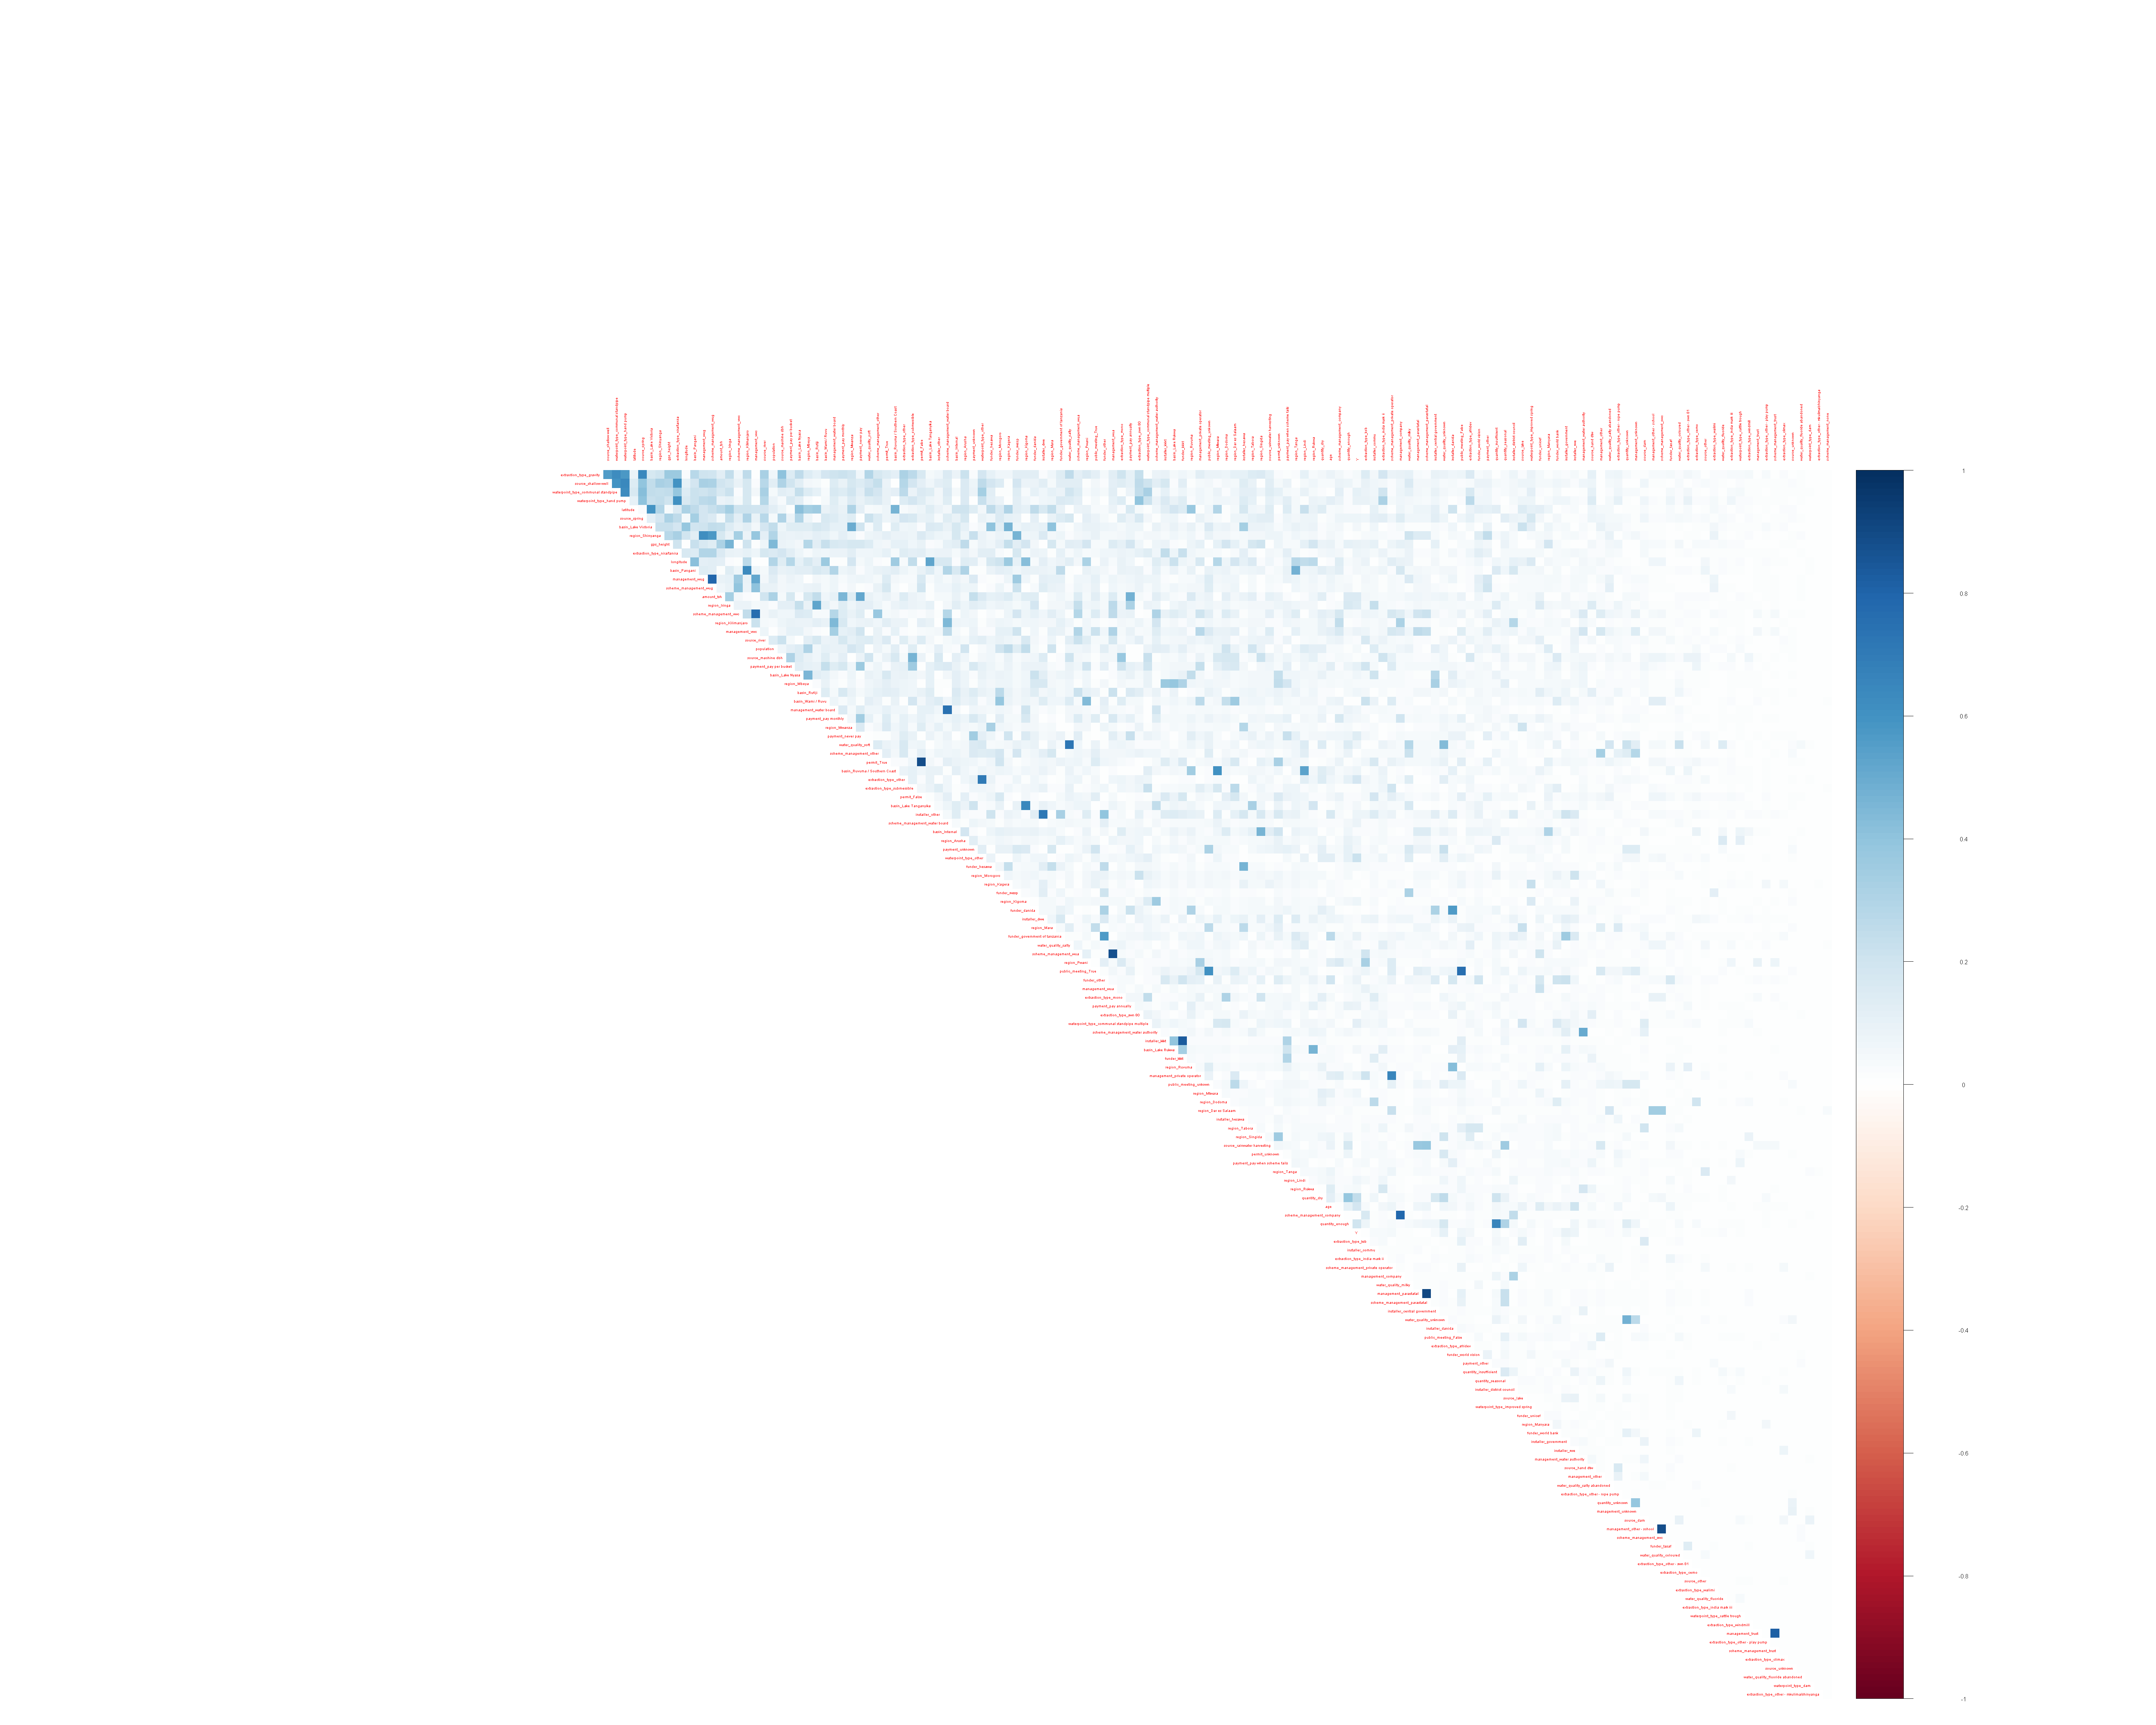

In [78]:
options(repr.plot.width = 50, repr.plot.height = 40)
training_explore<-cbind(final_train,Y)
training_explore$Y<-as.numeric(training_explore$Y)
cor_matrix<-abs(cor(training_explore))
diag(cor_matrix)<-0
corrplot(cor_matrix, diag = FALSE, order = "FPC",
         tl.pos = "td", tl.cex = 0.5, method = "color", type = "upper")
#https://stackoverflow.com/questions/45514140/r-corrplot-square-tile-size

With the prcomp function, R will find the principal components of the dataset.
To know how much information each component can explain, we take the standard deviation to find the variance and we divide the variance of the component with the sum of the variance of all components. 

Source: C. Dehon, "Analyse statistique multivariée, Stat-S-401", 2018.

In [79]:
prComp<-prcomp(final_train,scale. = TRUE)

In [80]:
std_dev <- prComp$sdev
pr_var <- std_dev^2
prop_varex <- pr_var/sum(pr_var)
sum(prop_varex[1:100])

[1] 0.9679795

Thanks to the last line of the previous cell, we find that the first 100 components explain 96,59% of the variance. It is illustrated in the next cell, with a graph showing how much information can be explained by the principal components and the cumulative proportion of variance. 

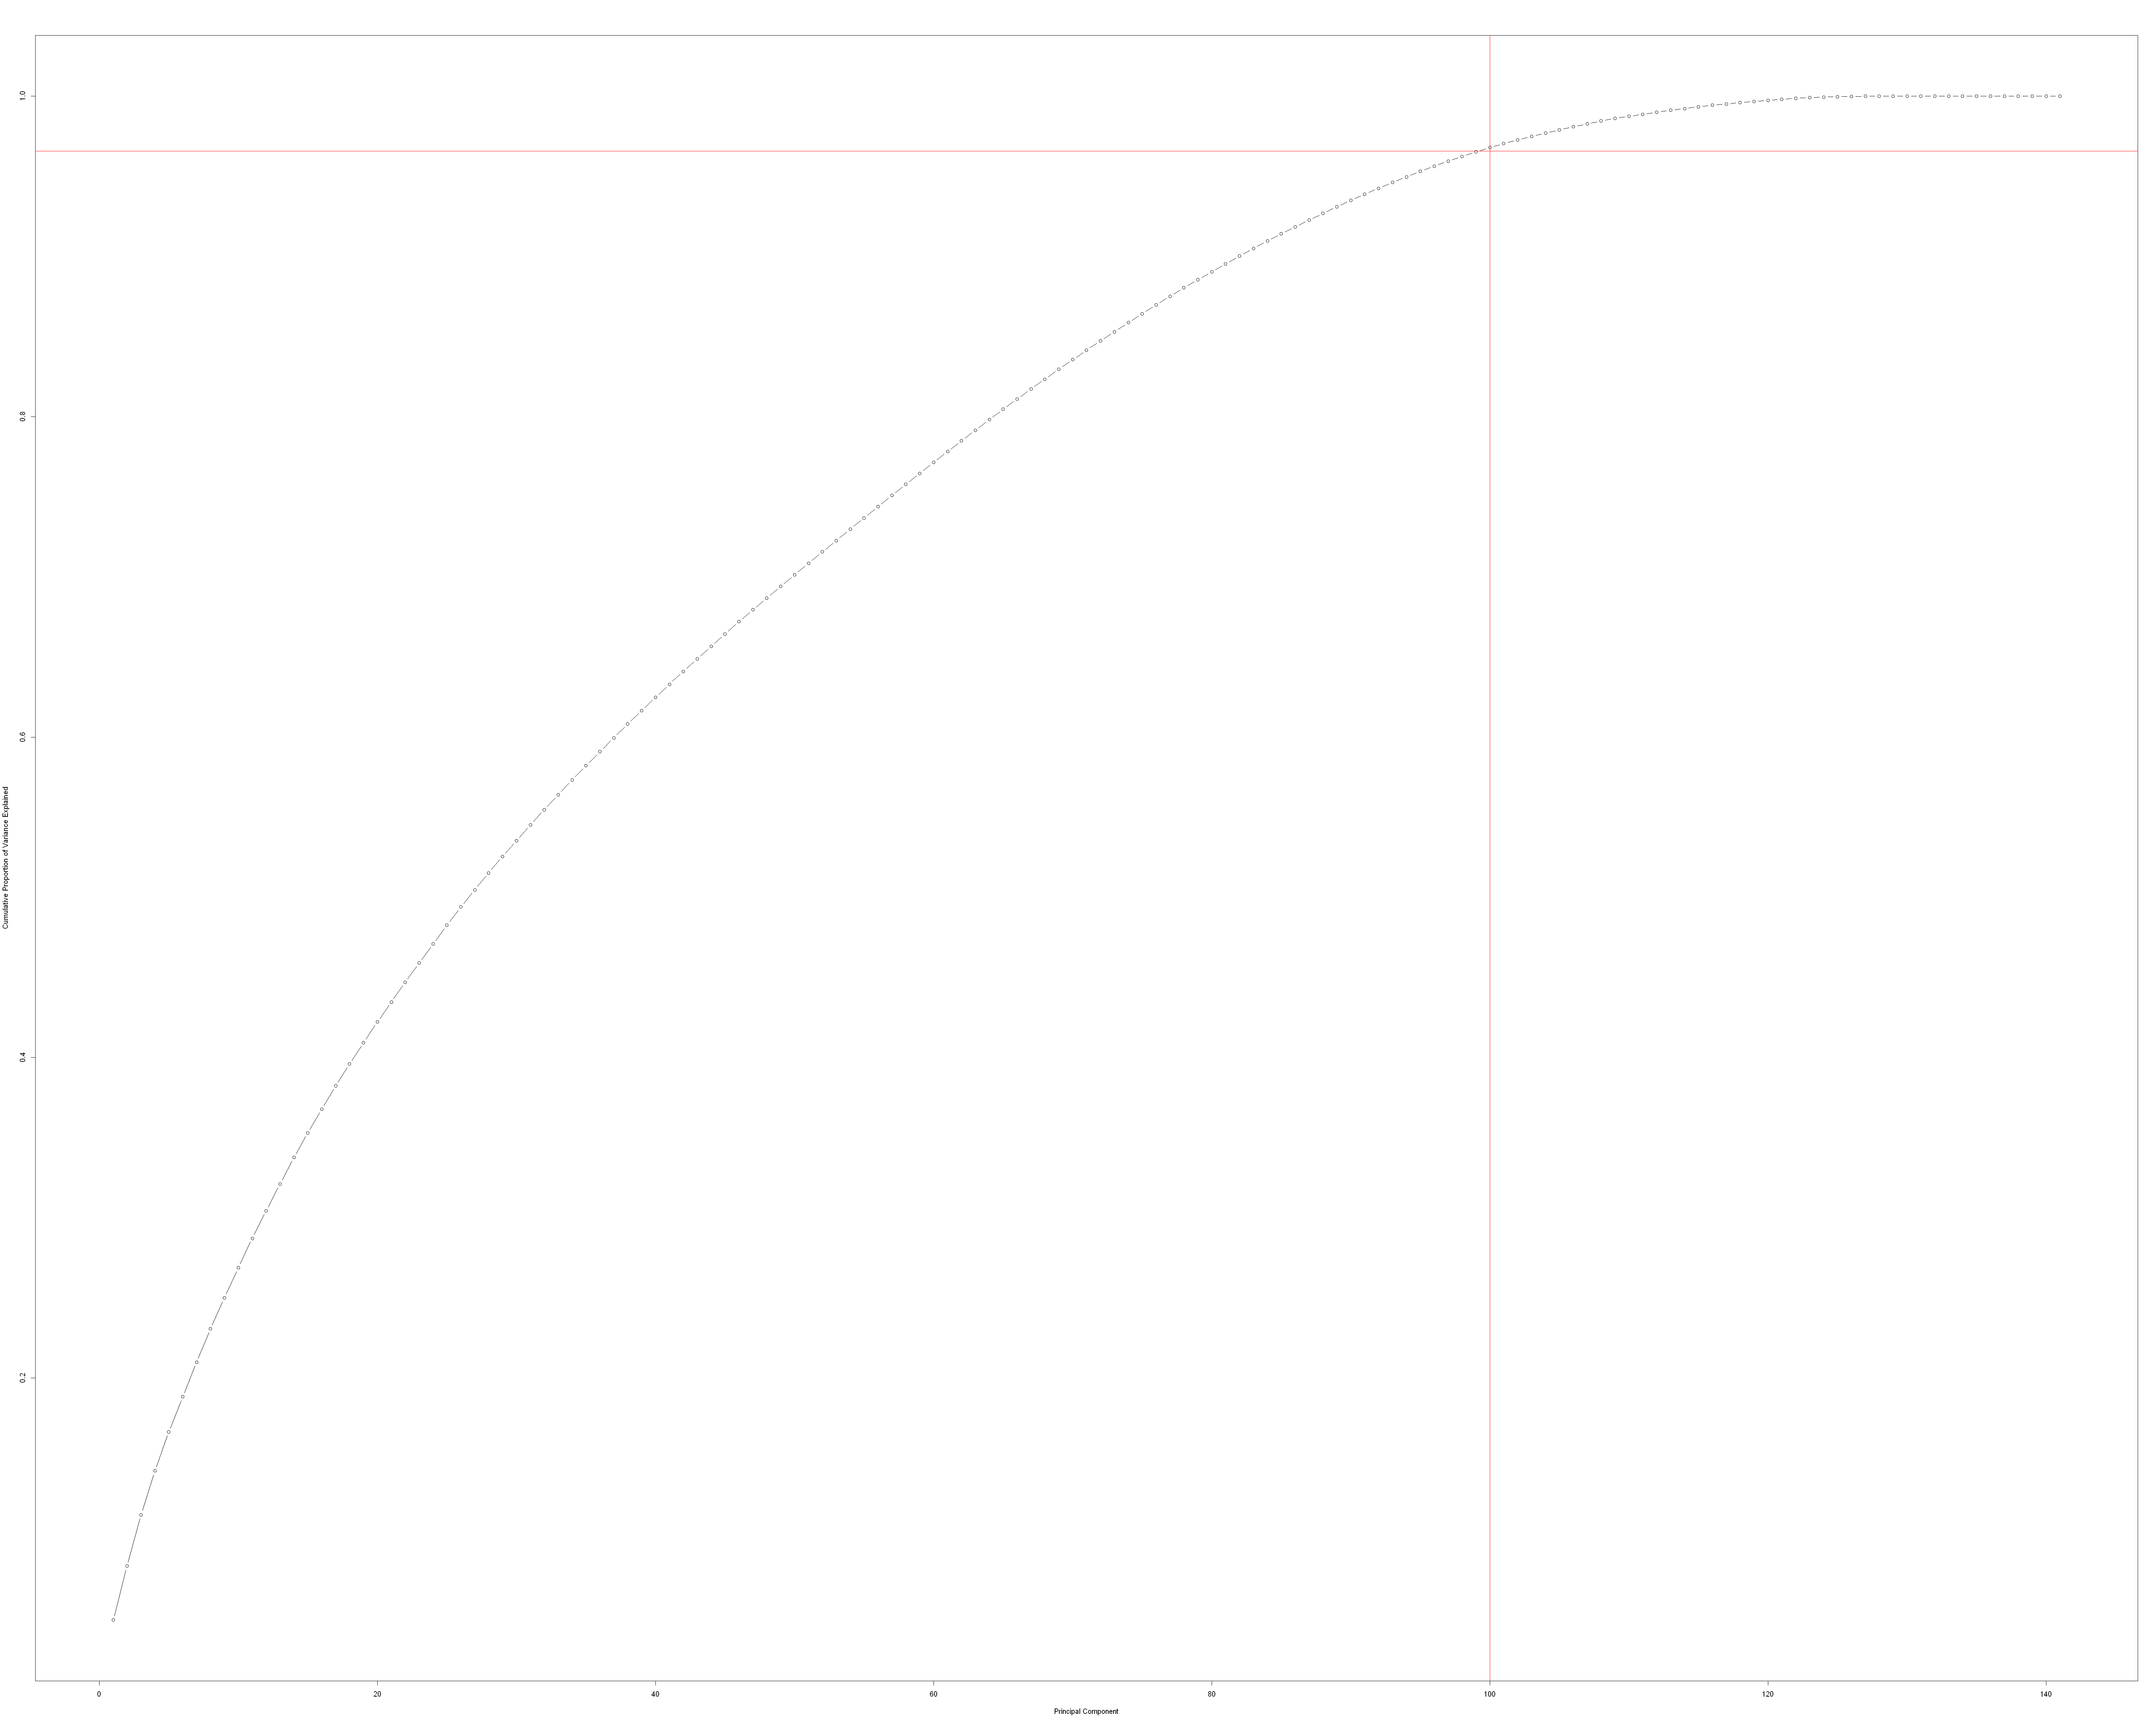

In [81]:
plot(cumsum(prop_varex), xlab = "Principal Component",ylab = "Cumulative Proportion of Variance Explained",type = "b")

abline(h=0.9659,col='red',v=100)

Now, that we have highlight the principal components of our dataset final_train, we make a new dataset containing only the 100 principal components that we found and the output in a colulmn that we call 'class'. 
On the graph x corresponds to the number of principal components and y is the cumulated variance explained. 
Thanks to the red lines, we see that 100 first components explain 96,59% of the variance. As said before, this means that we can go from 141 variables to 100 variables by only dropping 3.2% of the variance.

In [82]:
train.data<-data.frame(classe = Y, prComp$x)
train.data <- train.data[,1:101]

Let's have an idea of how train.data looks like. 
As expected, the first column is 'classe' and the rest of the columns are the 100 principal components.

In [83]:
head(train.data)

,classe,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,-4.0844941,0.17039126,0.3634385,-0.04016491,0.14671006,2.5483235,-0.3293843,-1.86318331,-1.2106501,...,-1.07996942,0.2305213,-0.4801658,-0.2265992,0.43209695,0.5064264,-1.9029735,0.5395774,0.709485828,1.35238819
2,0,-0.8883726,0.08862643,1.1126713,2.44032647,1.50579176,0.8212693,0.5745947,1.53769775,1.7573276,...,-0.50992672,-0.1093666,0.7019614,0.5900657,1.21453508,-1.0536291,0.2370084,-0.7330755,-0.656888862,0.63420334
3,0,0.2376733,4.10886154,0.8750183,-2.09790950,-0.08992059,-0.8313201,2.4817251,-0.42921314,-0.2061543,...,-0.51747904,0.4580271,1.0477444,-0.8877595,-0.57197878,-0.4072760,-0.5272480,-1.0051430,0.057598886,0.76180215
4,0,3.9751145,-0.37466822,-4.7554505,-0.24359635,0.17208149,-2.1802262,-0.1791345,-2.08016224,0.1309372,...,-0.54835908,0.3835413,-0.2004273,-0.2241427,-0.01536391,0.2111686,0.1428424,0.1030046,-0.008919525,-0.03891996
5,1,-2.0018542,1.43722904,1.5842291,-0.64492744,0.15293014,-0.8144660,0.7505204,-0.04218295,1.2675560,...,-0.08676647,-0.7476654,1.2215401,-0.4081284,-0.13245585,-1.1482044,-0.1030241,0.2453962,-0.390975928,0.52688018
6,0,0.6955926,7.68556153,-1.9518540,2.06832777,0.09301661,-2.1319639,2.1335707,1.19314725,-3.5036559,...,-0.68930513,-0.6794636,-0.9217924,-0.7067374,-0.15295818,0.6453302,-0.3732001,0.4994787,0.092495006,0.06830612


Now that we have created and saw how our new model looked like, we apply the nnet function to build a neural network with our dataset containing the principal components. What differs now is that the output Y is not a dataset apart anymore it is in the train.data dataset. 

Therefore, we must adapt our formula with y = train.data$classe, which selects the column "classe" in train.data, which corresponds to the output.

In [84]:
model_neur_pca <- nnet(x=train.data[,2:ncol(train.data)],y=class.ind(as.factor(train.data$classe)), size=10,skip=FALSE,Trace=FALSE,maxit=1000,MaxNWts=100000, rang=0.1)

# weights:  1043
initial  value 44539.637010 
iter  10 value 27014.037535
iter  20 value 24093.965689
iter  30 value 22453.468704
iter  40 value 21537.203477
iter  50 value 20861.888034
iter  60 value 20524.518754
iter  70 value 20325.745257
iter  80 value 20191.960477
iter  90 value 20100.479454
iter 100 value 20038.865211
iter 110 value 19990.860835
iter 120 value 19937.962635
iter 130 value 19907.626483
iter 140 value 19884.485511
iter 150 value 19863.199654
iter 160 value 19840.449794
iter 170 value 19823.080465
iter 180 value 19805.629302
iter 190 value 19784.271144
iter 200 value 19769.407046
iter 210 value 19748.023534
iter 220 value 19730.534850
iter 230 value 19713.149907
iter 240 value 19691.627821
iter 250 value 19664.200322
iter 260 value 19634.212233
iter 270 value 19594.912663
iter 280 value 19561.041750
iter 290 value 19522.530410
iter 300 value 19479.153290
iter 310 value 19426.921946
iter 320 value 19384.132645
iter 330 value 19348.983945
iter 340 value 19328.008759
it

We have built our neural network with train.data and the output y. 
We now can use the model to predict the output on final_test.
As before, with pred_test and Y_hat_test, we can have an overview of the probability of each waterpoint to be functional (0), non functional (1) or functional needs repair (2).

In [85]:
test.data<-predict(prComp, newdata = final_test)
test.data <- as.data.frame(test.data)
test.data <- test.data[,1:100]
pred_test <- predict(model_neur_pca, test.data)
head(pred_test)
Y_hat_test <-ifelse(pred_test[,1]>threshold,'0',ifelse(pred_test[,2]>threshold,'1','2'))
head(Y_hat_test)

,0,1,2
59401,0.809846702,0.09283970,0.08433715
59402,0.785796360,0.11938479,0.07264385
59403,0.817926606,0.10421147,0.05253184
59404,0.007005959,0.99415643,0.00000000
59405,1.000000000,0.01175233,0.04179420
59406,0.785796360,0.11938479,0.07264385


59401 59402 59403 59404 59405 59406 
  "0"   "0"   "0"   "1"   "0"   "0"

In [86]:
test.data<-predict(prComp, newdata = final_test)
test.data <- as.data.frame(test.data)
test.data <- test.data[,1:100]
pred_test <- predict(model_neur_pca, test.data)
head(pred_test)
Y_hat_test <-ifelse(pred_test[,1]>threshold,'functional',ifelse(pred_test[,2]>threshold,'non functional','functional needs repair'))
head(Y_hat_test)

,0,1,2
59401,0.809846702,0.09283970,0.08433715
59402,0.785796360,0.11938479,0.07264385
59403,0.817926606,0.10421147,0.05253184
59404,0.007005959,0.99415643,0.00000000
59405,1.000000000,0.01175233,0.04179420
59406,0.785796360,0.11938479,0.07264385


59401            59402            59403            59404 
    "functional"     "functional"     "functional" "non functional" 
           59405            59406 
    "functional"     "functional"

Our model predicts that waterpoints numbers: 


59401 : functional

59402 : functional 

59403 : functional

59404 : non functional

59405 : functional

59406 : functional


In [89]:
final_nnet_pca <-as.data.frame(cbind(test_init$id,Y_hat_test))
names(final_nnet_pca)[1]<-paste("id")
names(final_nnet_pca)[2]<-paste("status_group")
head(final_nnet_pca)

,id,status_group
,<chr>,<chr>
59401,50785,functional
59402,51630,functional
59403,17168,functional
59404,45559,non functional
59405,49871,functional
59406,52449,functional


In [90]:
write.csv(final_nnet_pca, file = "final_nnet_pca.csv",row.names=F)

Previously, we saw that the neural network with ten nodes had an accurcay of 74,38%. Here, after making the pca and used the 100 principal components of the dataset, the accuracy decreases to 73,58% accuracy with can be explained by the reduction of dimensionnality, which causes a loss of information in the "new" dataset. 


Therefore, we see that the model is more accurate without PCA and thus, we will not use the feature selection.

# Alternative models : XGBOOST


## xgBoost simple model 
 

We run an hyperparameter optimization using `caret` library. This was done using google collab pro. It was extremely time consuming, therefore, we only kept the model with the highest accuracy.Preparing the data for the XGBOOST algorithm.Je dois d'abord retrouver le bon modele dans mes fichiers.

In [ ]:
xgb_grid_1 = expand.grid(
  nrounds = 300,
  eta = c(0.03, 0.06, 0.09),
  max_depth=c(16,17,18,19),
  gamma = seq(0,1,0.1),
  colsample_bytree = seq(0,1,0.1),
  min_child_weight = 1,
  subsample = 1
)

In [ ]:
fitControl <- trainControl(
method = "repeatedcv",
number = 5,
repeats = 2,
returnData = FALSE,
summaryFunction = multiClassSummary
)

In [ ]:
tuneFit <- train( as.matrix(final_train) , as.factor(Y)
        , trControl = fitControl
        , tuneGrid = xgb_grid_1,
        method = "xgbTree", 
        metric = "Accuracy",
        eval_metric = "mlogloss"
)

The optimal parameters of tuneFit are the following:
`eta`=0.03
`max_depth`=17
`colsample_bytree`=0.4
`gamma`=0.8

We, therefore, run this model.

In [91]:
data_test_xgBoost <- as.matrix(as.data.frame(lapply(final_test, as.numeric)))
data_train_xgBoost <- as.matrix(as.data.frame(lapply(final_train, as.numeric)))
Y_xgBoost <-as.numeric(Y)
train.DMatrix <- xgb.DMatrix(data = data_train_xgBoost,label = Y_xgBoost)

In [92]:
boost_model <- xgboost(data = train.DMatrix, objective = "multi:softmax", booster = "gbtree",
                       ,eval_metric = "merror", nrounds = 300, 
                       num_class = 3,eta = .06, max_depth=18, colsample_bytree = .5,early_stopping_rounds = 10,
                       gamma=0.8)

[1]	train-merror:0.153889 
Will train until train_merror hasn't improved in 10 rounds.

[2]	train-merror:0.140960 
[3]	train-merror:0.140337 
[4]	train-merror:0.132071 
[5]	train-merror:0.131886 
[6]	train-merror:0.127088 
[7]	train-merror:0.125505 
[8]	train-merror:0.126347 
[9]	train-merror:0.123771 
[10]	train-merror:0.120842 
[11]	train-merror:0.118586 
[12]	train-merror:0.115505 
[13]	train-merror:0.114579 
[14]	train-merror:0.114579 
[15]	train-merror:0.114293 
[16]	train-merror:0.112811 
[17]	train-merror:0.111616 
[18]	train-merror:0.111465 
[19]	train-merror:0.109310 
[20]	train-merror:0.107155 
[21]	train-merror:0.105084 
[22]	train-merror:0.104848 
[23]	train-merror:0.105034 
[24]	train-merror:0.103013 
[25]	train-merror:0.101768 
[26]	train-merror:0.101044 
[27]	train-merror:0.100185 
[28]	train-merror:0.099108 
[29]	train-merror:0.098418 
[30]	train-merror:0.098721 
[31]	train-merror:0.098182 
[32]	train-merror:0.097037 
[33]	train-merror:0.096229 
[34]	train-merror:0.0957

In [93]:
predict_xgBoost <- predict(boost_model, data_test_xgBoost)

In [94]:
head(predict_xgBoost)

[1] 0 0 0 1 0 0

In [95]:
table(predict_xgBoost)

predict_xgBoost
   0    1    2 
9046 5269  535 

In [96]:
for (i in 1:length(predict_xgBoost)){
    if (predict_xgBoost[i]==0){
        predict_xgBoost[i]="functional"
    } else if (predict_xgBoost[i]==1){
        predict_xgBoost[i]="non functional"
        
    } else {

        predict_xgBoost[i]="functional needs repair"        
    }
}

head(predict_xgBoost)

[1] "functional"     "functional"     "functional"     "non functional"
[5] "functional"     "functional"

In [97]:
final_predict_xgBoost <-as.data.frame(cbind(test_init$id,predict_xgBoost))
names(final_predict_xgBoost)[1]<-paste("id")
names(final_predict_xgBoost)[2]<-paste("status_group")
head(final_predict_xgBoost)

,id,status_group
,<chr>,<chr>
1,50785,functional
2,51630,functional
3,17168,functional
4,45559,non functional
5,49871,functional
6,52449,functional


In [98]:
write.csv(final_predict_xgBoost, file = "final_predict_xgBoost2.csv",row.names=F)

Accuracy of 82.11%.

## xgBoost PCA
 

In [99]:
prComp<-prcomp(final_train,scale. = TRUE)

In [100]:
std_dev <- prComp$sdev
pr_var <- std_dev^2
prop_varex <- pr_var/sum(pr_var)
sum(prop_varex[1:100])

[1] 0.9679795

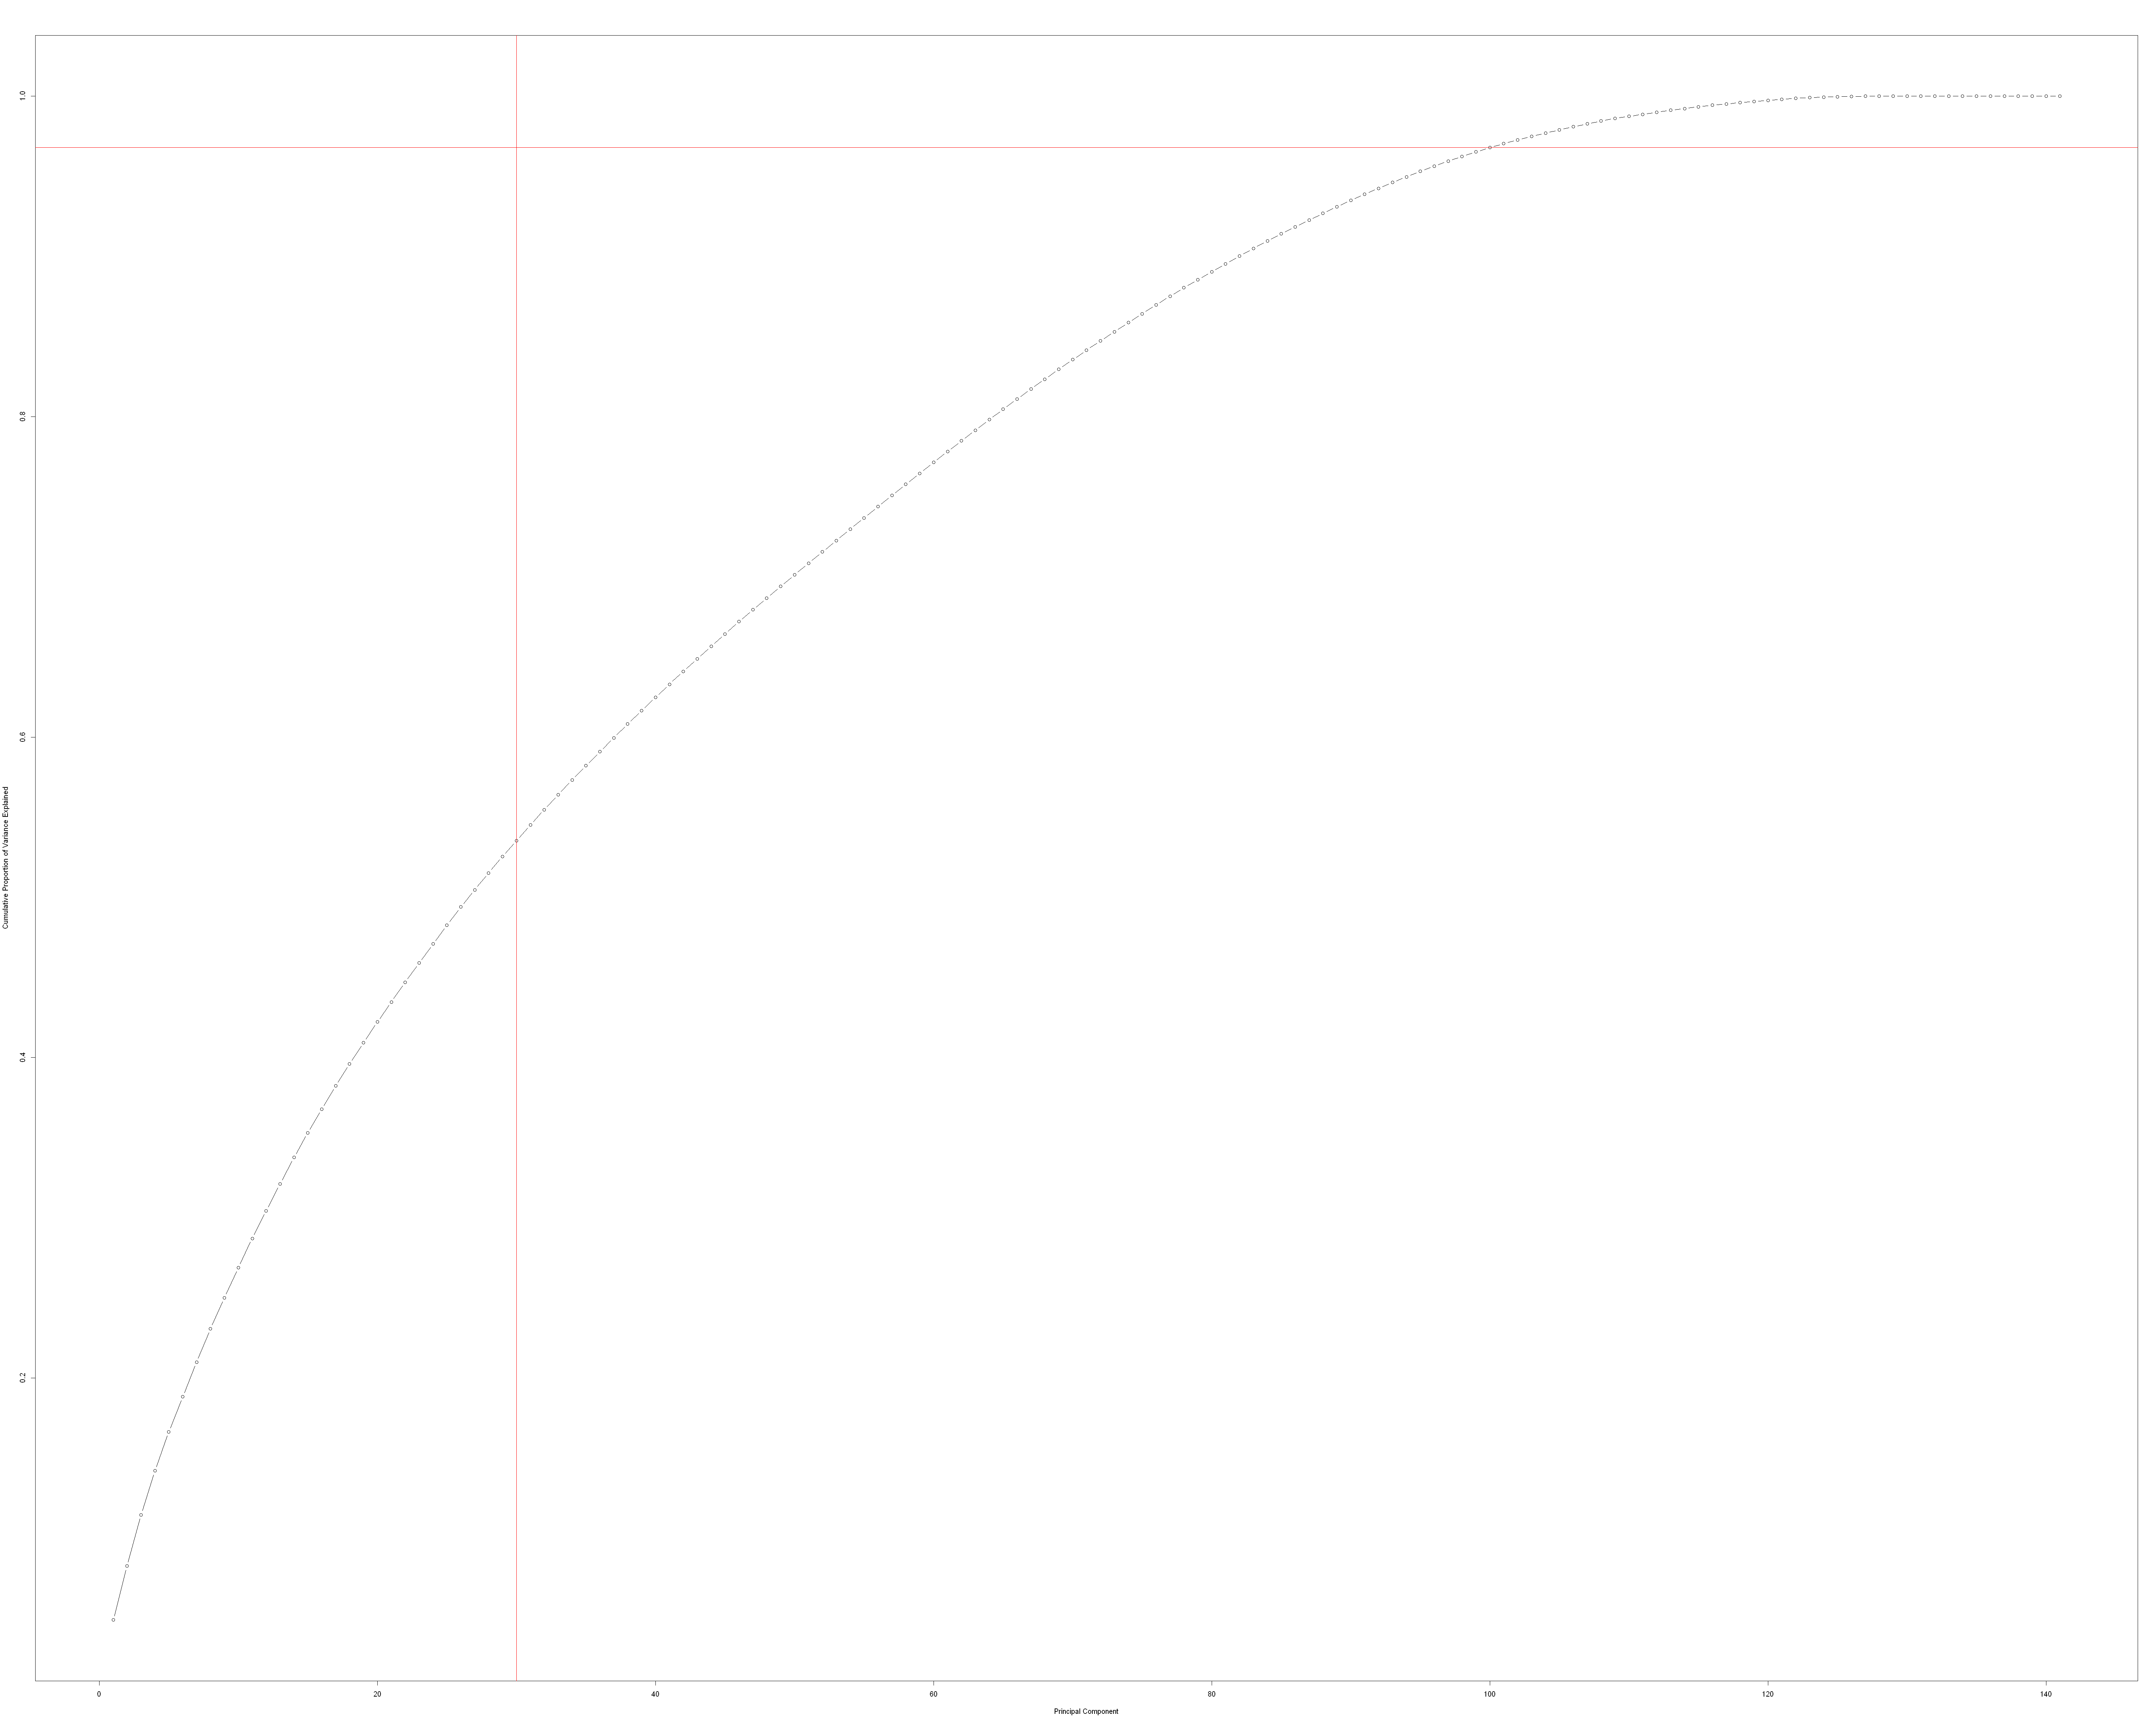

In [103]:
plot(cumsum(prop_varex), xlab = "Principal Component",ylab = "Cumulative Proportion of Variance Explained",type = "b")

abline(h=0.96797,col='red',v=30)

100 Principal Components explain about 96.8 % of total variance. So by using PCA, the dimensions are reduces from 140 to 100.

In [104]:
train.data<-data.frame(classe = Y, prComp$x)
train.data <- train.data[,2:101]

In [105]:
data_train_xgBoost_pca <- as.matrix(as.data.frame(lapply(train.data, as.numeric)))
Y_xgBoost <-as.numeric(Y)
train.DMatrix_pca <- xgb.DMatrix(data = data_train_xgBoost_pca,label = Y_xgBoost)

In [106]:
boost_model_pca <- xgboost(data = train.DMatrix_pca, objective = "multi:softmax", booster = "gbtree",
                       ,eval_metric = "merror", nrounds = 300, 
                       num_class = 3,eta = .06, max_depth=18, colsample_bytree = .5,early_stopping_rounds = 10,
                       gamma=0.8)

[1]	train-merror:0.093316 
Will train until train_merror hasn't improved in 10 rounds.

[2]	train-merror:0.072694 
[3]	train-merror:0.069175 
[4]	train-merror:0.065825 
[5]	train-merror:0.064293 
[6]	train-merror:0.062963 
[7]	train-merror:0.061852 
[8]	train-merror:0.061044 
[9]	train-merror:0.058973 
[10]	train-merror:0.057744 
[11]	train-merror:0.056936 
[12]	train-merror:0.055404 
[13]	train-merror:0.055118 
[14]	train-merror:0.053704 
[15]	train-merror:0.053013 
[16]	train-merror:0.052088 
[17]	train-merror:0.051279 
[18]	train-merror:0.050589 
[19]	train-merror:0.049731 
[20]	train-merror:0.049057 
[21]	train-merror:0.048266 
[22]	train-merror:0.047576 
[23]	train-merror:0.047003 
[24]	train-merror:0.045842 
[25]	train-merror:0.045202 
[26]	train-merror:0.044327 
[27]	train-merror:0.043552 
[28]	train-merror:0.042761 
[29]	train-merror:0.042037 
[30]	train-merror:0.041010 
[31]	train-merror:0.040741 
[32]	train-merror:0.040202 
[33]	train-merror:0.039461 
[34]	train-merror:0.0388

In [107]:
test.data<-predict(prComp, newdata = final_test)
test.data <- as.data.frame(test.data)
test.data <- test.data[,1:100]
data_test_xgBoost_pca <- as.matrix(as.data.frame(lapply(test.data, as.numeric)))
head(data_test_xgBoost_pca)

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100
-0.8723515,0.6209654,-3.1622929,-0.606295,-4.30243383,2.8703816,0.7191843,2.2652077,4.44126590,-4.39556298,...,0.06220299,0.72239870,0.1863221,1.1525712,-0.31461166,-0.3340274,-0.4822415,-0.03706075,0.6542177,0.4162554
2.4705785,-2.0684998,-0.7825192,-3.223383,0.07471969,-1.0616586,-1.2977544,-0.3355983,1.04501536,0.02061771,...,0.42753047,0.07360337,-0.2234134,0.4966143,-0.53318038,-0.3134787,-0.1066114,-0.22974802,0.3446585,-0.3791309
-0.7363733,1.2247429,-0.1611884,-2.309103,-2.83798330,2.5295562,0.9848893,-0.1624843,4.14326566,-2.25475087,...,-1.06708842,0.41544604,0.7240636,1.4562420,0.50598722,-1.0407682,0.3808560,0.59272571,-0.2382521,-0.1993942
-1.6166883,2.7906236,1.3273807,-1.255243,-0.50507708,2.7858826,-5.2556843,0.3412127,0.03515722,-0.99635382,...,1.27747180,-0.43266479,-0.2828639,-0.5638097,0.23976476,-0.2535903,-1.1544653,1.05795681,0.6845062,0.2934623
3.3239921,0.2861567,-2.1119728,2.631618,-0.09127501,1.2078548,-2.7384491,-0.6507581,-1.14595552,-0.30805359,...,0.53766072,0.02628101,-0.6754195,-0.4481243,0.46042950,1.2325615,1.0505196,-0.24916503,0.9619505,1.2265702
2.6139859,-2.1488871,-0.6937465,-2.807775,0.18086148,-0.9509706,-0.9866251,-0.3287883,0.59180815,0.50291062,...,0.17705855,0.21333156,-0.4024312,0.2618173,-0.08063912,-0.2413103,0.0495130,-0.05561481,0.5462873,-0.3163980


In [108]:
predict_xgBoost_pca <- predict(boost_model_pca, data_test_xgBoost_pca)

In [109]:
table(predict_xgBoost_pca)

predict_xgBoost_pca
   0    1    2 
8695 5464  691 

In [110]:
for (i in 1:length(predict_xgBoost_pca)){
    if (predict_xgBoost_pca[i]==0){
        predict_xgBoost_pca[i]="functional"
    } else if (predict_xgBoost_pca [i]==1){
        predict_xgBoost_pca[i]="non functional"
        
    } else {

        predict_xgBoost_pca[i]="functional needs repair"        
    }
}

head(predict_xgBoost)

[1] "functional"     "functional"     "functional"     "non functional"
[5] "functional"     "functional"

In [111]:
predict_xgBoost_pca <-as.data.frame(cbind(test_init$id,predict_xgBoost_pca))
names(predict_xgBoost_pca)[1]<-paste("id")
names(predict_xgBoost_pca)[2]<-paste("status_group")
head(predict_xgBoost_pca)

,id,status_group
,<chr>,<chr>
1,50785,non functional
2,51630,functional
3,17168,functional
4,45559,non functional
5,49871,functional
6,52449,functional


In [112]:
write.csv(predict_xgBoost_pca, file = "final_predict_xgBoost_pca.csv",row.names=F)

As with the other models PCA provides less accurate results.